# Funding Liquidity and Interest Rate Risk Management in Modern Banks: A Quantitative Modeling Approach
## Interest Rate and Deposit Flow Copula Model
### Joseph Daher, Manaswi Gupta, Turner McLaurin, Freddy Platinus

## Summary


## Setup
### Required Packages

In [28]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import stats
import datetime as dt
from pandas_datareader import data as pdr
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm
from scipy.stats import norm

### WRDS Connection
This project uses data from WRDS (Wharton Research Data Services). Instructions [here](https://wrds-www.wharton.upenn.edu/pages/support/programming-wrds/programming-python/python-from-your-computer/) on how to authorize WRDS connection.

In [2]:
import wrds
db = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [29]:
## Bank Codes
bank_codes = {
    7213: "Citi",
    6548: "US Bank",
    6384: "PNC",
    9846: "Truist",
    6672: "FifthThird",
    12368: "Regions",
    17534: "KeyBank",
    57957: "Citizens",
    9396: "Valley",
    18053: "BankOfHawaii",
    24735: "SiliconValley",
    59017: "FirstRepublic",
}

In [36]:
# -----------------------------
# 1. Connect + choose a bank
# -----------------------------

FDIC_CERT = 24735  # Silicon Valley Bank

# -----------------------------
# 2. WRDS query: assets, deposits, wholesale funding
# -----------------------------
query = f"""
    WITH latest_submissions AS (
        SELECT
            rssd9050,
            wrdsreportdate,
            MAX(rssdsubmissiondate) AS max_submission
        FROM bank.wrds_call_rcfd_1
        WHERE rssd9050 IN ({FDIC_CERT})
        GROUP BY rssd9050, wrdsreportdate
    )
    SELECT
        /* ============================
           IDENTIFIERS
           ============================ */
        r1.wrdsreportdate              AS report_date,
        r1.rssd9050                    AS fdic_cert,
        r1.rssd9001                    AS rssd_id,           -- RSSD ID (not ABA)

        /* ============================
           CORE BALANCE SHEET (CONSOLIDATED)
           ============================ */
        r2.rcfd2170                    AS total_assets,          -- TOTAL ASSETS (RCFD2170)
        r2.rcfd2122                    AS total_loans,           -- LOANS & LEASES, NET (RCFD2122 / B529-ish)
        r2.rcfd3210                    AS total_equity,          -- TOTAL EQUITY CAPITAL (RCFD3210)
        r2.rcfd2948                    AS total_liabs_minority,  -- TOTAL LIABILITIES & MINORITY INTEREST (RCFD2948)

        /* ============================
           TOTAL DEPOSITS (CONSOLIDATED)
           ============================ */
        rdep.rcfn2200                  AS total_deposits,        -- TOTAL DEPOSITS (RCFN2200)

        /* ============================
           HQLA BUILDING BLOCKS
           (Level 1 & Level 2A candidates)
           ============================ */

        -- Cash & balances: RC-A / RC
        r1.rcfd0010                    AS cash_and_balances,         -- CASH & BALANCES DUE (RCFD0010: total)
        r1.rcfd0081                    AS cash_nonint_coin,          -- NONINT-BEARING BALANCES & COIN (RCFD0081)
        r1.rcfd0071                    AS interest_bearing_balances, -- INTEREST-BEARING BALANCES (RCFD0071)

        -- Very liquid money-market assets in domestic offices
        rcon1.rconb987                 AS fedfunds_sold_domestic,    -- FEDERAL FUNDS SOLD (RCONB987)
        rcon2.rconb989                 AS repos_bought_domestic,     -- SECURITIES PURCHASED UNDER REPO (RCONB989)

        -- Securities totals (to split into Level 1 / 2A in Python)
        r1.rcfd1754                    AS securities_htm_total,      -- HTM SECURITIES; TOTAL (RCFD1754)
        r1.rcfd1773                    AS securities_afs_total,      -- AFS DEBT SECURITIES; TOTAL (RCFD1773)

        -- Trading assets (can be haircut or partially counted)
        r2.rcfd3545                    AS trading_assets_total,      -- TRADING ASSETS; TOTAL (RCFD3545)

        /* ============================
           WHOLESALE / NON-DEPOSIT FUNDING
           (CONSOLIDATED + DOMESTIC)
           ============================ */

        -- Consolidated wholesale-style liabilities (RCFD_1 / RCFD_2)
        r1.rcfd3190                    AS other_borrowed_money_consol,  -- OTHER BORROWED MONEY (RCFD3190; older)
        r2.rcfd3200                    AS subordinated_debt_consol,     -- SUBORD NOTES & DEBENTURES (RCFD3200)
        r2.rcfdb989                    AS repos_bought_consol,          -- SECURITIES PURCHASED UNDER REPO (RCFDB989)
        r2.rcfdb995                    AS repos_sold_consol,            -- SECURITIES SOLD UNDER REPO (RCFDB995)

        -- Domestic wholesale funding (RCON_1 / RCON_2)
        rcon1.rconb993                 AS fedfunds_purchased_domestic,  -- FED FUNDS PURCHASED IN DOMESTIC OFFICES (RCONB993)
        rcon2.rconb995                 AS repos_sold_domestic,          -- SECURITIES SOLD UNDER REPO (RCONB995)
        rcon2.rcon3190                 AS other_borrowed_money_domestic,-- OTHER BORROWED MONEY (RCON3190)

        /* ============================
           DOMESTIC DEPOSITS (RCON)
           ============================ */
        rcon2.rcon2200                 AS total_deposits_domestic,      -- TOTAL DOMESTIC DEPOSITS (RCON2200)
        rcon2.rcon6631                 AS nonint_deposits_domestic,     -- NONINTEREST-BEARING (RCON6631)
        rcon2.rcon6636                 AS intbearing_deposits_domestic  -- INTEREST-BEARING (RCON6636)

    FROM bank.wrds_call_rcfd_1 r1
    INNER JOIN latest_submissions ls
        ON  r1.rssd9050           = ls.rssd9050
        AND r1.wrdsreportdate     = ls.wrdsreportdate
        AND r1.rssdsubmissiondate = ls.max_submission

    /* Consolidated balance sheet extension (RCFD_2) */
    LEFT JOIN bank.wrds_call_rcfd_2 r2
        ON  r1.rssd9050           = r2.rssd9050
        AND r1.wrdsreportdate     = r2.wrdsreportdate
        AND r1.rssdsubmissiondate = r2.rssdsubmissiondate

    /* Total deposits (RCFN_1, consolidated) */
    LEFT JOIN bank.wrds_call_rcfn_1 rdep
        ON  r1.rssd9050           = rdep.rssd9050
        AND r1.wrdsreportdate     = rdep.wrdsreportdate
        AND r1.rssdsubmissiondate = rdep.rssdsubmissiondate

    /* Domestic balance sheet / funding detail (RCON_1: fed funds sold/purchased) */
    LEFT JOIN bank.wrds_call_rcon_1 rcon1
        ON  r1.rssd9050           = rcon1.rssd9050
        AND r1.wrdsreportdate     = rcon1.wrdsreportdate
        AND r1.rssdsubmissiondate = rcon1.rssdsubmissiondate

    /* Domestic balance sheet + deposits + other borrowed money (RCON_2) */
    LEFT JOIN bank.wrds_call_rcon_2 rcon2
        ON  r1.rssd9050           = rcon2.rssd9050
        AND r1.wrdsreportdate     = rcon2.wrdsreportdate
        AND r1.rssdsubmissiondate = rcon2.rssdsubmissiondate

    WHERE r1.rssd9050 IN ({FDIC_CERT})
    ORDER BY r1.rssd9050, r1.wrdsreportdate;
"""

panel = db.raw_sql(query)
panel["report_date"] = pd.to_datetime(panel["report_date"])
panel = panel.sort_values(["fdic_cert", "report_date"]).reset_index(drop=True)

panel.to_csv(f"{FDIC_CERT}.csv", index=False)
panel

,report_date,fdic_cert,rssd_id,total_assets,total_loans,total_equity,total_liabs_minority,total_deposits,cash_and_balances,cash_nonint_coin,...,other_borrowed_money_consol,subordinated_debt_consol,repos_bought_consol,repos_sold_consol,fedfunds_purchased_domestic,repos_sold_domestic,other_borrowed_money_domestic,total_deposits_domestic,nonint_deposits_domestic,intbearing_deposits_domestic
0,2001-03-31,24735,802866,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,9,4065675.0,372176,3693499.0
1,2001-06-30,24735,802866,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,3666568.0,262641,3403927.0
2,2001-09-30,24735,802866,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,66413,3477299.0,135220,3342079.0
3,2001-12-31,24735,802866,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,66888,3395268.0,246944,3148324.0
4,2002-03-31,24735,802866,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,0,0,67363,3195018.0,219385,2975633.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2021-12-31,24735,802866,208581000.0,66275000.0,14795000,193786000.0,16053000,13125000,2040000,...,60000,0,599000,61000,0,61000,60000,175378000.0,121685000,53693000.0
84,2022-03-31,24735,802866,217804000.0,68664000.0,14571000,203233000.0,17612000,19663000,1640000,...,36000,0,417000,63000,0,63000,36000,182802000.0,124113000,58689000.0
85,2022-06-30,24735,802866,211824000.0,70954000.0,15386000,196438000.0,15196000,14269000,1747000,...,3653000,0,539000,50000,0,50000,3653000,174957000.0,110885000,64072000.0
86,2022-09-30,24735,802866,210244000.0,72128000.0,15129000,195115000.0,13537000,13032000,1330000,...,13516000,0,393000,36000,0,36000,13516000,165341000.0,92151000,73190000.0


### Balance Sheet over Time

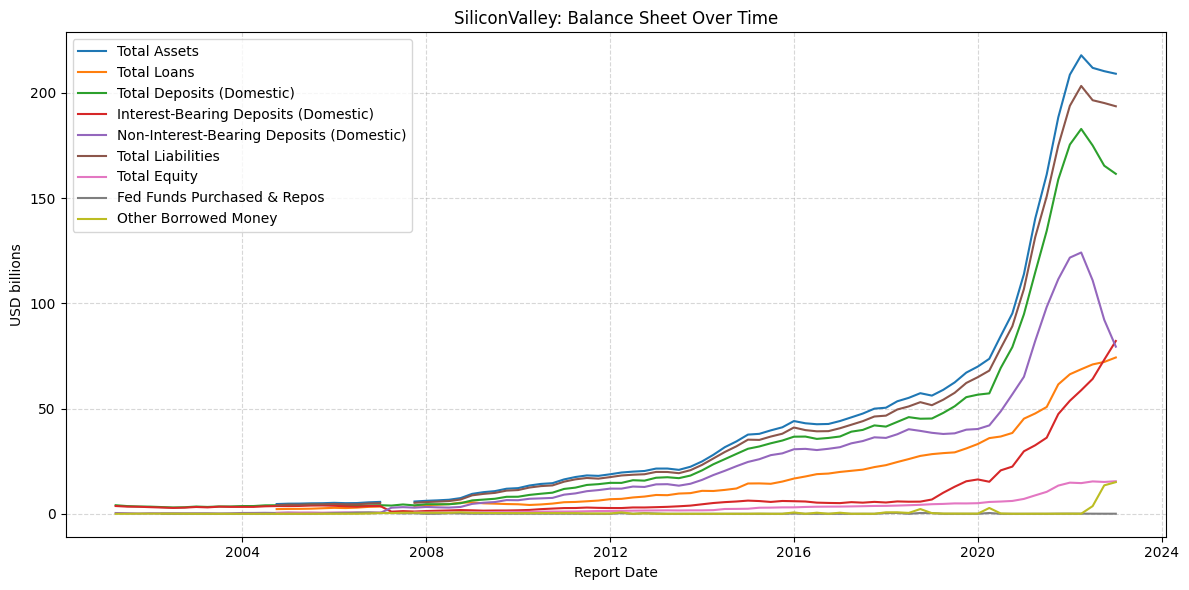

In [37]:
panel["total_assets_bn"]            = panel["total_assets"] / 1e6
panel["total_loans_bn"]             = panel["total_loans"] / 1e6
panel["total_deposits_bn"]          = panel["total_deposits_domestic"] / 1e6  # <-- THIS is deposits
panel["intbearing_deposits_domestic_bn"] = panel["intbearing_deposits_domestic"] / 1e6
panel["nonint_deposits_domestic_bn"] = panel["nonint_deposits_domestic"] / 1e6
panel["total_liabs_minority_bn"]    = panel["total_liabs_minority"] / 1e6
panel["total_equity_bn"]            = panel["total_equity"] / 1e6
panel["fedfunds_purchased_repos_bn"] = (panel["fedfunds_purchased_domestic"] + panel["repos_sold_domestic"]) / 1e6
panel["other_borrowed_money_domestic_bn"]    = panel["other_borrowed_money_domestic"] / 1e6

plt.figure(figsize=(12, 6))

plt.plot(panel["report_date"], panel["total_assets_bn"],         label="Total Assets")
plt.plot(panel["report_date"], panel["total_loans_bn"],          label="Total Loans")
plt.plot(panel["report_date"], panel["total_deposits_bn"],       label="Total Deposits (Domestic)")
plt.plot(panel["report_date"], panel["intbearing_deposits_domestic_bn"], label="Interest-Bearing Deposits (Domestic)")
plt.plot(panel["report_date"], panel["nonint_deposits_domestic_bn"], label="Non-Interest-Bearing Deposits (Domestic)")
plt.plot(panel["report_date"], panel["total_liabs_minority_bn"], label="Total Liabilities")
plt.plot(panel["report_date"], panel["total_equity_bn"],         label="Total Equity")
plt.plot(panel["report_date"], panel["fedfunds_purchased_repos_bn"], label="Fed Funds Purchased & Repos")
plt.plot(panel["report_date"], panel["other_borrowed_money_domestic_bn"], label="Other Borrowed Money")

plt.title(f"{bank_codes[FDIC_CERT]}: Balance Sheet Over Time")
plt.xlabel("Report Date")
plt.ylabel("USD billions")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Historical Deposit Flow Distributions

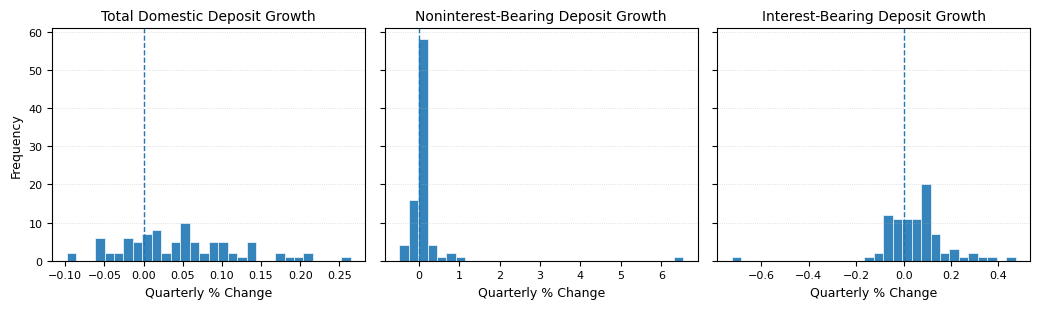

In [38]:
panel = panel.sort_values(["fdic_cert", "report_date"]).reset_index(drop=True)

# Total domestic deposits
panel["dep_total_pct"] = panel["total_deposits_domestic"].pct_change()

# Noninterest-bearing deposits (stickier)
panel["dep_nonint_pct"] = panel["nonint_deposits_domestic"].pct_change()

# Interest-bearing deposits (rate-sensitive)
panel["dep_int_pct"] = panel["intbearing_deposits_domestic"].pct_change()


fig, axes = plt.subplots(1, 3, figsize=(10.5, 3.2), sharey=True)
series = [
    ("dep_total_pct",  "Total Domestic Deposit Growth"),
    ("dep_nonint_pct", "Noninterest-Bearing Deposit Growth"),
    ("dep_int_pct",    "Interest-Bearing Deposit Growth"),
]

for ax, (col, title) in zip(axes, series):
    x = panel[col].dropna()
    ax.hist(x, bins=30, edgecolor="white", linewidth=0.5, alpha=0.9)
    ax.axvline(0, linestyle="--", linewidth=1)
    ax.set_title(title, fontsize=10, pad=6)
    ax.set_xlabel("Quarterly % Change", fontsize=9)
    ax.tick_params(axis="both", labelsize=8)
    ax.grid(axis="y", linestyle=":", linewidth=0.6, alpha=0.5)

axes[0].set_ylabel("Frequency", fontsize=9)

fig.tight_layout()
plt.show()


## Fed Funds Rate Data

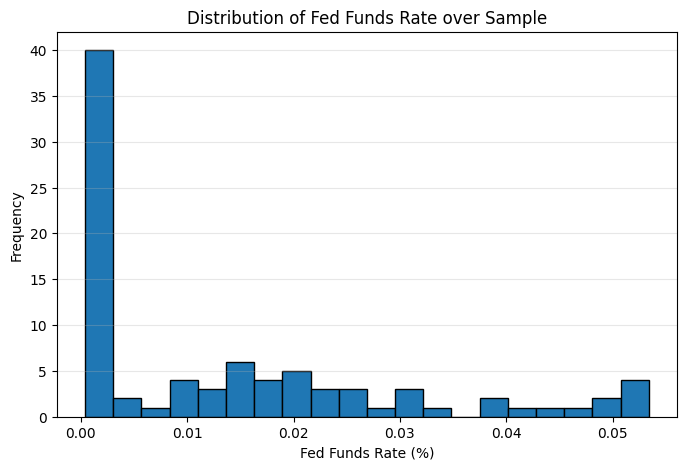

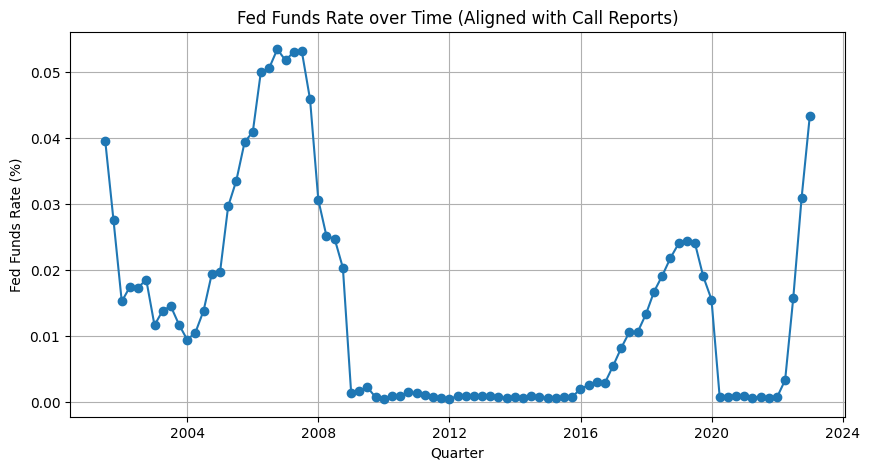

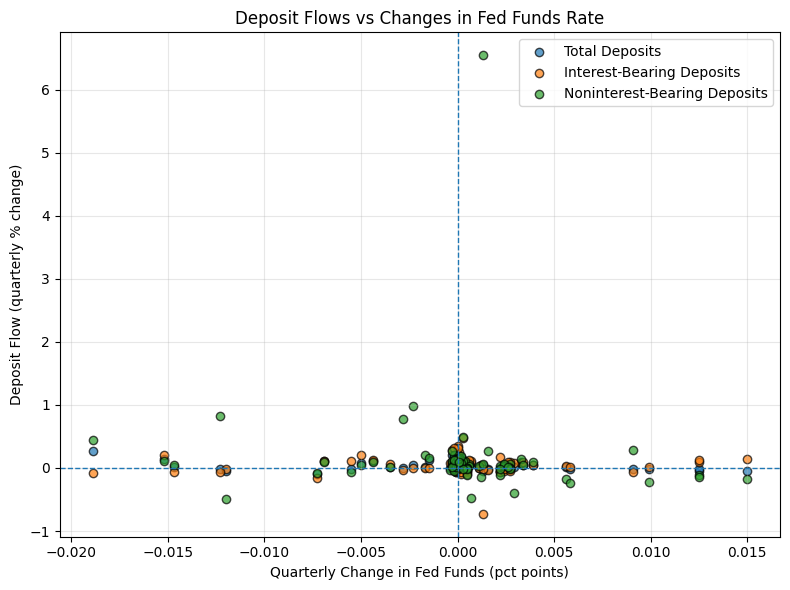

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

# ----------------------------------------------------
# 1. Deposit flows and outflows
# ----------------------------------------------------
panel = panel.sort_values("report_date").reset_index(drop=True)

# ----- FLOWS (symmetric) -----
panel["flow_total"]  = panel["total_deposits_domestic"].pct_change()
panel["flow_int"]    = panel["intbearing_deposits_domestic"].pct_change()
panel["flow_nonint"] = panel["nonint_deposits_domestic"].pct_change()

# ----- OUTFLOWS (one-sided) -----
panel["outflow_total"]  = -panel["flow_total"].clip(upper=0)
panel["outflow_int"]    = -panel["flow_int"].clip(upper=0)
panel["outflow_nonint"] = -panel["flow_nonint"].clip(upper=0)

# ----------------------------------------------------
# 2. Pull Fed funds via FRED API, quarterly, aligned to Call dates
# ----------------------------------------------------
FRED_API_KEY = "a8837523b7c200b627e6e1f1a7275566"

# Use Fed Funds (monthly) or EFFR (daily). Pick ONE:
SERIES_ID = "EFFR"

# Use the panel date span (recommended) unless you want fixed dates
START_DATE = panel["report_date"].min().strftime("%Y-%m-%d")
END_DATE   = panel["report_date"].max().strftime("%Y-%m-%d")

def fetch_fred_series(series_id, start_date, end_date, api_key):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        "observation_start": start_date,
        "observation_end": end_date,
    }
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    data = r.json()

    obs = data["observations"]
    dates = [o["date"] for o in obs]
    values = []
    for o in obs:
        v = o["value"]
        values.append(np.nan if v == "." else float(v))

    out = pd.DataFrame({"date": pd.to_datetime(dates), "rate_pct": values}).set_index("date")
    return out

rates_raw = fetch_fred_series(SERIES_ID, START_DATE, END_DATE, FRED_API_KEY)

# Clean/interpolate small gaps
rates = rates_raw.copy()
rates["rate_pct"] = rates["rate_pct"].astype(float).interpolate(limit_direction="both")

# Quarterly alignment:
rates_q = rates.resample("QE").last()
rates_q.index = rates_q.index.to_period("Q").to_timestamp("Q")  # quarter-end timestamps
rates_q = rates_q.rename(columns={"rate_pct": "fed_funds"})
rates_q["fed_funds"] = rates_q["fed_funds"] / 100.0   # percent -> decimal

panel = panel.merge(
    rates_q[["fed_funds"]],
    left_on="report_date",
    right_index=True,
    how="left"
)
panel = panel.loc[:, ~panel.columns.duplicated()]

# Quarterly change in Fed funds (percentage points)
panel["fedfunds_change"] = panel["fed_funds"].diff()

# ----------------------------------------------------
# 3. Fed funds level + changes: histograms and scatter
# ----------------------------------------------------
plt.figure(figsize=(8, 5))
plt.hist(panel["fed_funds"].dropna(), bins=20, edgecolor="black")
plt.xlabel("Fed Funds Rate (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Fed Funds Rate over Sample")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(panel["report_date"], panel["fed_funds"], marker="o")
plt.xlabel("Quarter")
plt.ylabel("Fed Funds Rate (%)")
plt.title("Fed Funds Rate over Time (Aligned with Call Reports)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(panel["fedfunds_change"], panel["flow_total"],  alpha=0.7, edgecolor="black", label="Total Deposits")
plt.scatter(panel["fedfunds_change"], panel["flow_int"],    alpha=0.7, edgecolor="black", label="Interest-Bearing Deposits")
plt.scatter(panel["fedfunds_change"], panel["flow_nonint"], alpha=0.7, edgecolor="black", label="Noninterest-Bearing Deposits")
plt.axhline(0, linestyle="--", linewidth=1)
plt.axvline(0, linestyle="--", linewidth=1)
plt.xlabel("Quarterly Change in Fed Funds (pct points)")
plt.ylabel("Deposit Flow (quarterly % change)")
plt.title("Deposit Flows vs Changes in Fed Funds Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Gaussian Copula (Empirical)
Using fed funds rate.

Gaussian copula correlation (rho): -0.3228822538866303


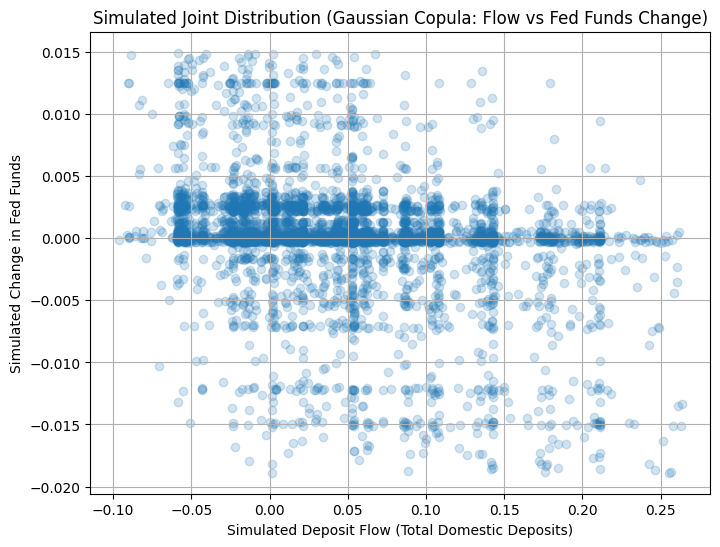

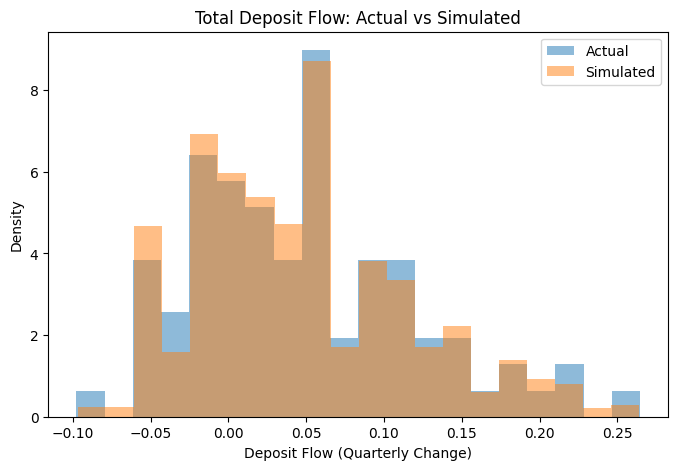

In [41]:
# ----------------------------------------------------
# 1. Select variables: total deposit flow vs rate change
#    (assumes panel has 'flow_total' and 'fedfunds_change')
# ----------------------------------------------------
df = panel[["flow_total", "fedfunds_change"]].dropna().copy()

x = df["flow_total"].values        # quarterly deposit flow (∆ deposits / lagged deposits)
y = df["fedfunds_change"].values   # quarterly change in Fed funds (in same units as pulled)

n = len(df)

# ----------------------------------------------------
# 2. Rank-based empirical CDFs -> uniforms
# ----------------------------------------------------
u_x = (stats.rankdata(x, method="average") - 0.5) / n
u_y = (stats.rankdata(y, method="average") - 0.5) / n

# Avoid exact 0 / 1 for inverse normal
eps = 1e-6
u_x = np.clip(u_x, eps, 1 - eps)
u_y = np.clip(u_y, eps, 1 - eps)

# Map uniforms to standard normals
z_x = stats.norm.ppf(u_x)
z_y = stats.norm.ppf(u_y)

# ----------------------------------------------------
# 3. Estimate Gaussian copula correlation
# ----------------------------------------------------
rho = np.corrcoef(z_x, z_y)[0, 1]
print("Gaussian copula correlation (rho):", rho)

# ----------------------------------------------------
# 4. Simulate from the fitted Gaussian copula
# ----------------------------------------------------
num_sim = 5000

cov = np.array([[1,    rho],
                [rho,  1  ]])

# Simulated latent normals
z_sim = np.random.multivariate_normal(mean=[0.0, 0.0], cov=cov, size=num_sim)

# Back to uniforms
u_sim = stats.norm.cdf(z_sim)
u_x_sim = u_sim[:, 0]
u_y_sim = u_sim[:, 1]

def empirical_quantile(u, sample):
    return np.quantile(sample, u)

# Map simulated uniforms through empirical marginals
x_sim = empirical_quantile(u_x_sim, x)   # simulated flow_total
y_sim = empirical_quantile(u_y_sim, y)   # simulated fedfunds_change

# ----------------------------------------------------
# 5. Diagnostic plots
# ----------------------------------------------------
# Joint simulated cloud
plt.figure(figsize=(8, 6))
plt.scatter(x_sim, y_sim, alpha=0.2)
plt.xlabel("Simulated Deposit Flow (Total Domestic Deposits)")
plt.ylabel("Simulated Change in Fed Funds")
plt.title("Simulated Joint Distribution (Gaussian Copula: Flow vs Fed Funds Change)")
plt.grid(True)
plt.show()

# Compare marginals: actual vs simulated (deposit flow)
plt.figure(figsize=(8, 5))
plt.hist(x,     bins=20, alpha=0.5, label="Actual",     density=True)
plt.hist(x_sim, bins=20, alpha=0.5, label="Simulated", density=True)
plt.legend()
plt.title("Total Deposit Flow: Actual vs Simulated")
plt.xlabel("Deposit Flow (Quarterly Change)")
plt.ylabel("Density")
plt.show()

### Nicer Gaussian Copula Plot

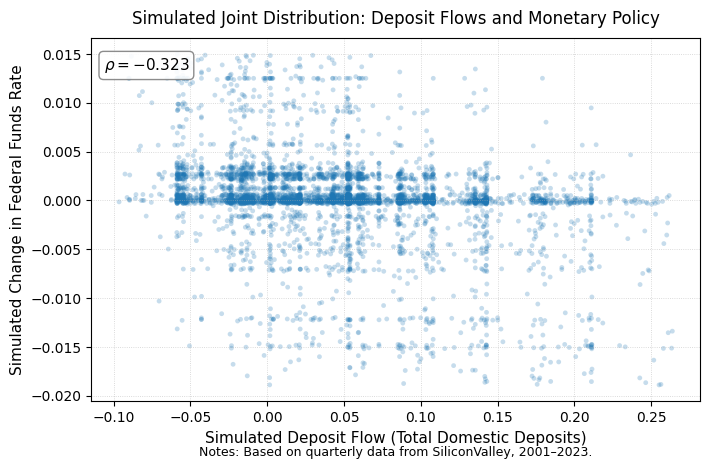

In [42]:
plt.figure(figsize=(7.2, 4.8))

plt.scatter(
    x_sim,
    y_sim,
    s=12,
    alpha=0.25,
    color="tab:blue",
    edgecolors="none"
)

plt.xlabel("Simulated Deposit Flow (Total Domestic Deposits)", fontsize=11)
plt.ylabel("Simulated Change in Federal Funds Rate", fontsize=11)

plt.title(
    "Simulated Joint Distribution: Deposit Flows and Monetary Policy",
    fontsize=12,
    pad=10
)

# Info box with correlation
plt.text(
    0.02,
    0.95,
    rf"$\rho = {rho:.3f}$",
    transform=plt.gca().transAxes,
    fontsize=11,
    verticalalignment="top",
    bbox=dict(
        boxstyle="round",
        facecolor="white",
        edgecolor="gray",
        alpha=0.9
    )
)

# Data note
plt.text(
    0.5,
    -0.15,
    f"Notes: Based on quarterly data from {bank_codes.get(FDIC_CERT)}, 2001–2023.",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha="center"
)

plt.grid(
    which="major",
    linestyle=":",
    linewidth=0.6,
    alpha=0.6
)

plt.tick_params(axis="both", labelsize=10)
plt.tight_layout()
plt.show()

## Vasicek Interest Rate Model

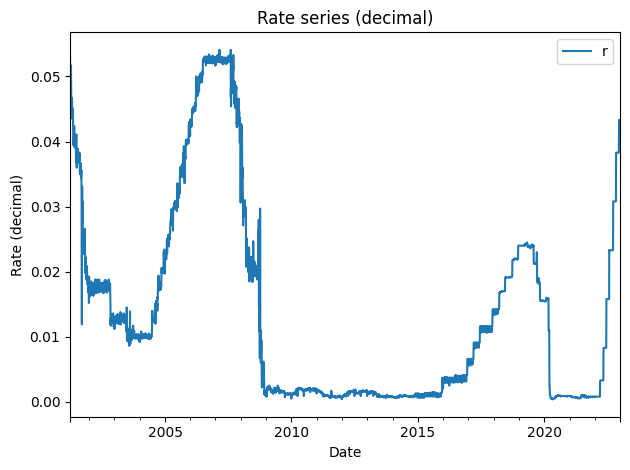

AR(1) regression:
 alpha = 1.696944e-05
 beta  = 0.998655
 s2    = 5.455848e-07
 R^2   = 0.9978

Estimated Vasicek (OU) parameters:
a (speed)      = 0.3392  per year
b (long-run)   = 1.2617%  (decimal)
sigma (vol)    = 1.1733% per sqrt(year)

One-quarter-ahead predictive distribution for r_T:
 r0      = 4.3300%
 mean    = 4.0806%
 std dev = 0.5627%


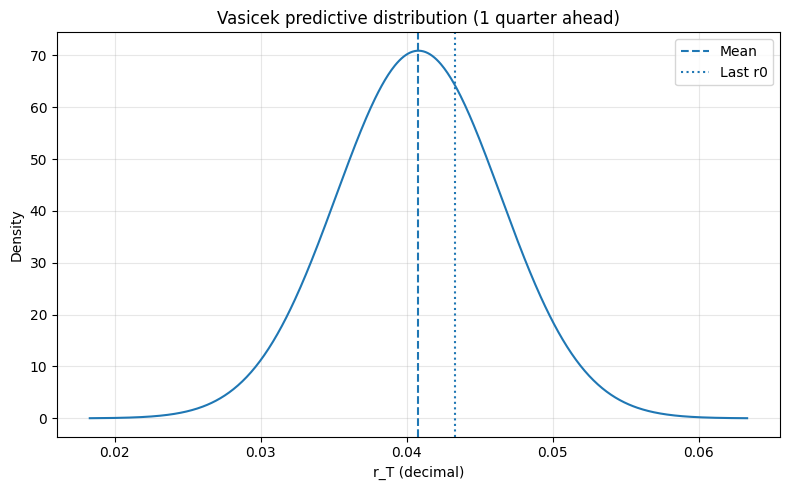

In [50]:
# ------------------------------------------------------------
# 1. Load + preprocess rate series (daily)
#   rates_raw must be produced by fetch_fred_series(...)
#   with columns: ["rate_pct"] or here we assume ["rate_pct"] exists
# ------------------------------------------------------------
rates = rates_raw.copy()
rates["rate_pct"] = rates["rate_pct"].astype(float)
rates["rate_pct"] = rates["rate_pct"].interpolate(limit_direction="both")

# % -> decimal
rates["r"] = rates["rate_pct"] / 100.0
rates = rates[["r"]].dropna()

# Optional quick look
rates.plot(title="Rate series (decimal)")
plt.xlabel("Date")
plt.ylabel("Rate (decimal)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 2. AR(1): r_{t+1} = alpha + beta r_t + eps
# ------------------------------------------------------------
r_series = rates["r"]
r_t   = r_series.shift(1).dropna()
r_tp1 = r_series.loc[r_t.index]
df_reg = pd.DataFrame({"r_t": r_t, "r_tp1": r_tp1}).dropna()

delta = 1.0 / 252.0  # business-day step in years

X = sm.add_constant(df_reg["r_t"])
y = df_reg["r_tp1"]
model = sm.OLS(y, X).fit()

alpha = float(model.params["const"])
beta  = float(model.params["r_t"])
s2    = float(model.mse_resid)

print("AR(1) regression:")
print(f" alpha = {alpha:.6e}")
print(f" beta  = {beta:.6f}")
print(f" s2    = {s2:.6e}")
print(f" R^2   = {model.rsquared:.4f}")

phi = beta
if not (0 < phi < 1):
    print("Warning: beta not in (0,1); mean-reversion interpretation may be problematic.")

# ------------------------------------------------------------
# 3. Convert AR(1) -> Vasicek params (continuous-time OU)
#   phi = exp(-a*delta)  => a = -ln(phi)/delta
#   b = alpha/(1-phi)
#   Var(eps) = (sigma^2/(2a)) * (1 - exp(-2a delta))
# ------------------------------------------------------------
a = -np.log(phi) / delta
b = alpha / (1.0 - phi)

sigma2 = s2 * (2.0 * a) / (1.0 - np.exp(-2.0 * a * delta))
sigma = np.sqrt(sigma2)

print("\nEstimated Vasicek (OU) parameters:")
print(f"a (speed)      = {a:.4f}  per year")
print(f"b (long-run)   = {b:.4%}  (decimal)")
print(f"sigma (vol)    = {sigma:.4%} per sqrt(year)")

# ------------------------------------------------------------
# 4. 1-quarter-ahead predictive distribution
# ------------------------------------------------------------
r0 = float(r_series.iloc[-1])
T_horizon = 0.25  # <-- one quarter forward

m_T = b + (r0 - b) * np.exp(-a * T_horizon)
v_T = (sigma**2 / (2.0 * a)) * (1.0 - np.exp(-2.0 * a * T_horizon))
std_T = np.sqrt(v_T)

print("\nOne-quarter-ahead predictive distribution for r_T:")
print(f" r0      = {r0:.4%}")
print(f" mean    = {m_T:.4%}")
print(f" std dev = {std_T:.4%}")

# Plot analytic pdf
x_grid = np.linspace(m_T - 4*std_T, m_T + 4*std_T, 600)
pdf = norm.pdf(x_grid, loc=m_T, scale=std_T)

plt.figure(figsize=(8,5))
plt.plot(x_grid, pdf)
plt.axvline(m_T, linestyle="--", label="Mean")
plt.axvline(r0, linestyle=":", label="Last r0")
plt.title("Vasicek predictive distribution (1 quarter ahead)")
plt.xlabel("r_T (decimal)")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Number of quarterly observations used: 86
t-copula correlation (rho_t): -0.3273599351872017
Latest quarter deposits (domestic): 161.5 bn
Approximate HQLA stock:            49.8 bn
95% LaR (one quarter): 8.85 bn
99% LaR (one quarter): 10.71 bn


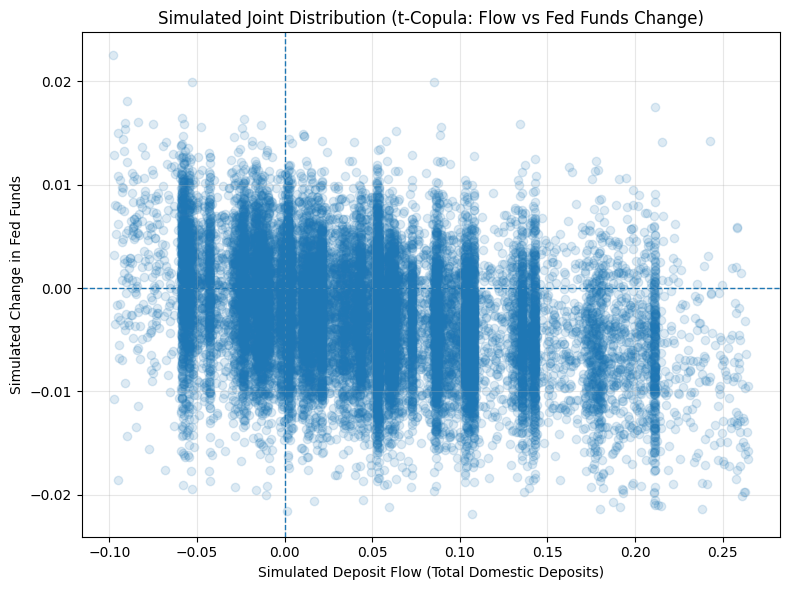

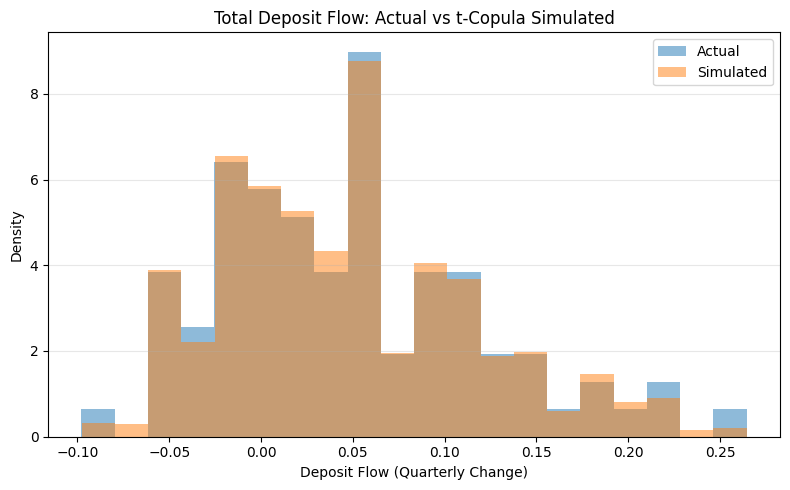

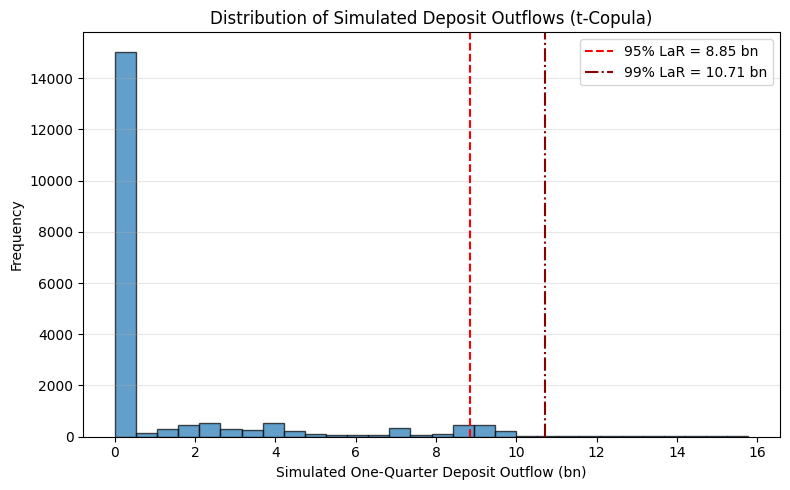

In [51]:
# ====================================================
# 0. Data prep: use only rows with both vars present
# ====================================================
df = panel[["flow_total", "fedfunds_change"]].dropna().copy()

x = df["flow_total"].values        # quarterly deposit flow (ratio)
y = df["fedfunds_change"].values   # quarterly change in Fed funds (level units)

n = len(df)
print(f"Number of quarterly observations used: {n}")

# ====================================================
# 1. t-copula fit (rank -> uniforms -> t-variates)
# ====================================================

# Rank-based empirical CDF -> uniforms in (0,1)
u_x = (stats.rankdata(x, method="average") - 0.5) / n
u_y = (stats.rankdata(y, method="average") - 0.5) / n

eps = 1e-6
u_x = np.clip(u_x, eps, 1 - eps)
u_y = np.clip(u_y, eps, 1 - eps)

# Choose degrees of freedom for t-copula (low df = heavier tails)
nu = 10

# Map uniforms to t_nu margins
t_x = stats.t.ppf(u_x, df=nu)
t_y = stats.t.ppf(u_y, df=nu)

# Estimate correlation matrix of latent t-variates
rho_t = np.corrcoef(t_x, t_y)[0, 1]
print("t-copula correlation (rho_t):", rho_t)

Sigma = np.array([[1.0,    rho_t],
                  [rho_t,  1.0 ]])

# ====================================================
# 2. Simulate from the fitted t-copula
# ====================================================

# After you have estimated a, b, sigma and have r0 and T_horizon
def vasicek_marginal_params(r0, a, b, sigma, T):
    """Return mean and std of r_T under Vasicek over horizon T (in years)."""
    m_T = b + (r0 - b) * np.exp(-a * T)
    v_T = sigma**2 / (2.0 * a) * (1.0 - np.exp(-2.0 * a * T))
    return m_T, np.sqrt(v_T)

T_horizon = 0.25   # or 0.25 if you want a 1-quarter horizon
m_T, std_T = vasicek_marginal_params(r0, a, b, sigma, T_horizon)

def sample_multivariate_t(mu, Sigma, df, size):
    """
    Draw samples from multivariate t with location mu, scale Sigma, df degrees.
    For copula purposes we only care about dependence, not scale.
    """
    dim = len(mu)
    g = np.random.standard_normal(size=(size, dim))
    L = np.linalg.cholesky(Sigma)
    z = g @ L.T                  # correlated normals
    w = np.random.chisquare(df, size=size)
    return mu + z / np.sqrt(w / df)[:, None]

num_sim = 20_000

t_sim = sample_multivariate_t(
    mu=np.zeros(2),
    Sigma=Sigma,
    df=nu,
    size=num_sim
)

# Back to uniforms via t CDF
u_sim = stats.t.cdf(t_sim, df=nu)
u_x_sim = u_sim[:, 0]
u_y_sim = u_sim[:, 1]

def empirical_quantile(u, sample):
    return np.quantile(sample, u)

# Map simulated uniforms through empirical marginals
flow_sim = empirical_quantile(u_x_sim, x)   # simulated total deposit flow

# Rates: Vasicek marginal instead of empirical
r_T_sim = stats.norm.ppf(u_y_sim, loc=m_T, scale=std_T)
rate_sim = r_T_sim - r0   # simulated change in fed funds

# ====================================================
# 3. One-step Liquidity-at-Risk from latest balance sheet
# ====================================================

# --- Current balance sheet snapshot (latest report) ---
latest = panel.sort_values("report_date").iloc[-1]

# Call Report amounts are in $ thousands; convert to billions when reporting
D0_thousands = latest["total_deposits_domestic"]
D0_bn = D0_thousands / 1e6

# Approximate HQLA stock (very stylized haircuts)
HQLA_thousands = (
    latest["cash_and_balances"]                    # Level 1
    + latest["interest_bearing_balances"]          # Level 1-ish
    + latest["securities_afs_total"]               # treat as Level 1/2A
)
HQLA_bn = HQLA_thousands / 1e6

print(f"Latest quarter deposits (domestic): {D0_bn:.1f} bn")
print(f"Approximate HQLA stock:            {HQLA_bn:.1f} bn")

# --- From simulated flows to simulated outflows ---
# New deposit level next quarter for each simulation
D1_thousands = D0_thousands * (1.0 + flow_sim)

# Outflow amount = max(D0 - D1, 0)
outflow_thousands = np.maximum(D0_thousands - D1_thousands, 0.0)
outflow_bn = outflow_thousands / 1e6

# LaR at chosen confidence levels
alpha_95 = 0.95
alpha_99 = 0.99

LaR_95 = np.quantile(outflow_bn, alpha_95)
LaR_99 = np.quantile(outflow_bn, alpha_99)

print(f"95% LaR (one quarter): {LaR_95:.2f} bn")
print(f"99% LaR (one quarter): {LaR_99:.2f} bn")

# ====================================================
# 4. Plots
# ====================================================

# (A) Joint simulated cloud (flow vs rate change)
plt.figure(figsize=(8, 6))
plt.scatter(flow_sim, rate_sim, alpha=0.15)
plt.axvline(0, linestyle="--", linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("Simulated Deposit Flow (Total Domestic Deposits)")
plt.ylabel("Simulated Change in Fed Funds")
plt.title("Simulated Joint Distribution (t-Copula: Flow vs Fed Funds Change)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# (B) Marginal check: actual vs simulated flows
plt.figure(figsize=(8, 5))
plt.hist(x,        bins=20, alpha=0.5, label="Actual",    density=True)
plt.hist(flow_sim, bins=20, alpha=0.5, label="Simulated", density=True)
plt.xlabel("Deposit Flow (Quarterly Change)")
plt.ylabel("Density")
plt.title("Total Deposit Flow: Actual vs t-Copula Simulated")
plt.legend()
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# (C) Distribution of simulated outflows with LaR lines
plt.figure(figsize=(8, 5))
plt.hist(outflow_bn, bins=30, edgecolor="black", alpha=0.7)
plt.axvline(LaR_95, color="red",  linestyle="--", label=f"95% LaR = {LaR_95:.2f} bn")
plt.axvline(LaR_99, color="darkred", linestyle="-.", label=f"99% LaR = {LaR_99:.2f} bn")
plt.xlabel("Simulated One-Quarter Deposit Outflow (bn)")
plt.ylabel("Frequency")
plt.title("Distribution of Simulated Deposit Outflows (t-Copula)")
plt.legend()
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

Last-period LCR (approx): 1.59


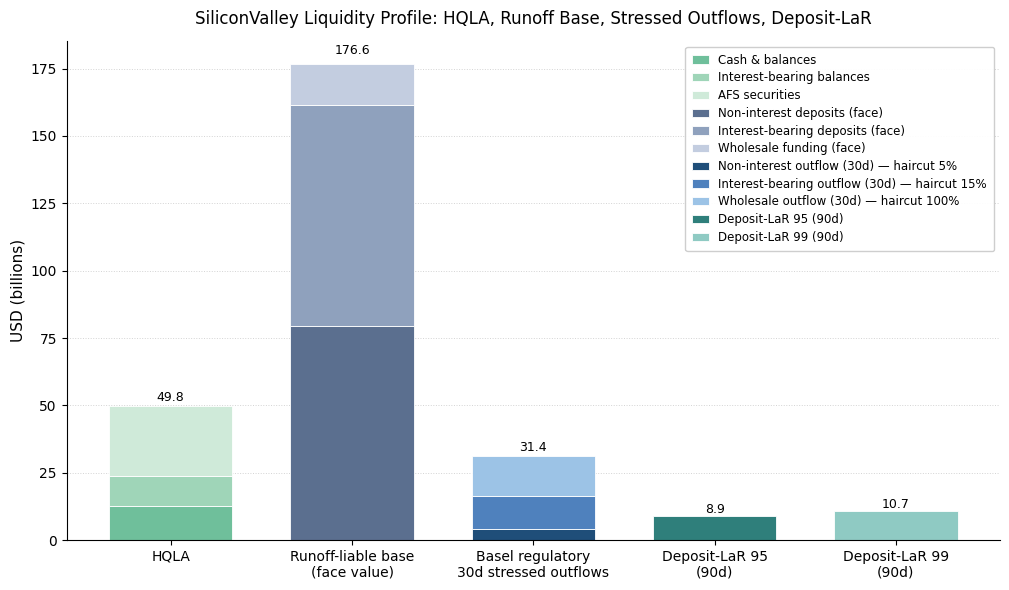

In [52]:
# ---------------------------------------------
# Last available quarter snapshot
# ---------------------------------------------
latest = panel.sort_values("report_date").iloc[-1]

# ========== HQLA COMPONENTS (in billions) ==========
cash_bn        = latest["cash_and_balances"]         / 1e6
ib_bal_bn      = latest["interest_bearing_balances"] / 1e6
afs_bn         = latest["securities_afs_total"]      / 1e6

HQLA_bn = cash_bn + ib_bal_bn + afs_bn

# Total domestic deposits (billions)
total_deposits_bn = latest["total_deposits_domestic"] / 1e6

# ========== RUNOFF-LIABLE BASE (face values, in billions) ==========
nonint_dep_thousands = latest["nonint_deposits_domestic"]
int_dep_thousands    = latest["intbearing_deposits_domestic"]

# Wholesale base (you may only have some of these; default to 0 if missing)
fedfunds_purchased_thousands = latest.get("fedfunds_purchased_domestic", 0.0)
repos_sold_thousands         = latest.get("repos_sold_domestic", 0.0)
other_borr_thousands         = latest.get("other_borrowed_money_domestic", 0.0)

wholesale_base_thousands = (
    fedfunds_purchased_thousands
    + repos_sold_thousands
    + other_borr_thousands
)

nonint_dep_bn    = nonint_dep_thousands / 1e6
int_dep_bn       = int_dep_thousands    / 1e6
wholesale_base_bn = wholesale_base_thousands / 1e6

runoff_base_total_bn = nonint_dep_bn + int_dep_bn + wholesale_base_bn

# ========== STRESSED 30-DAY OUTFLOWS (in billions) ==========
# You can refine these runoff factors to be closer to regulatory LCR if desired
runoff_nonint      = 0.05   # 5% on "stable" noninterest-bearing
runoff_int         = 0.15   # 15% on interest-bearing
runoff_wholesale   = 1.00   # 100% on wholesale (very conservative)

outflow_nonint_thousands = runoff_nonint    * nonint_dep_thousands
outflow_int_thousands    = runoff_int       * int_dep_thousands
outflow_wholesale_thousands = runoff_wholesale * wholesale_base_thousands

outflow_nonint_bn    = outflow_nonint_thousands    / 1e6
outflow_int_bn       = outflow_int_thousands       / 1e6
outflow_wholesale_bn = outflow_wholesale_thousands / 1e6

net_30d_outflow_bn = outflow_nonint_bn + outflow_int_bn + outflow_wholesale_bn

# Approximate LCR
LCR_last = HQLA_bn / net_30d_outflow_bn
print(f"Last-period LCR (approx): {LCR_last:.2f}")

labels = [
    "HQLA",
    "Runoff-liable base\n(face value)",
    "Basel regulatory\n30d stressed outflows",
    "Deposit-LaR 95\n(90d)",
    "Deposit-LaR 99\n(90d)",
]
x = np.arange(len(labels))
bar_w = 0.68

# Neutral, paper-style palettes (distinct per stacked bar)
hqlA_cols = ["#6fbf9b", "#9fd5b8", "#cfead9"]
base_cols = ["#5b6f8f", "#8fa1bd", "#c3cde0"]
outflow_cols = ["#1f4e79", "#4f81bd", "#9cc3e6"]
lar_cols = ["#2f7f7b", "#8fcac3"]

fig, ax = plt.subplots(figsize=(10.2, 6.0))

# --- Style ---
ax.set_axisbelow(True)
ax.grid(axis="y", linestyle=":", linewidth=0.7, alpha=0.55)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# -----------------------------
# Bar 0: HQLA stack
# -----------------------------
b = 0.0
ax.bar(x[0], cash_bn,   width=bar_w, bottom=b, color=hqlA_cols[0], label="Cash & balances", edgecolor="white", linewidth=0.6)
b += cash_bn
ax.bar(x[0], ib_bal_bn, width=bar_w, bottom=b, color=hqlA_cols[1], label="Interest-bearing balances", edgecolor="white", linewidth=0.6)
b += ib_bal_bn
ax.bar(x[0], afs_bn,    width=bar_w, bottom=b, color=hqlA_cols[2], label="AFS securities", edgecolor="white", linewidth=0.6)

# -----------------------------
# Bar 1: Runoff-liable base (face)
# -----------------------------
b = 0.0
ax.bar(x[1], nonint_dep_bn,     width=bar_w, bottom=b, color=base_cols[0], label="Non-interest deposits (face)", edgecolor="white", linewidth=0.6)
b += nonint_dep_bn
ax.bar(x[1], int_dep_bn,        width=bar_w, bottom=b, color=base_cols[1], label="Interest-bearing deposits (face)", edgecolor="white", linewidth=0.6)
b += int_dep_bn
ax.bar(x[1], wholesale_base_bn, width=bar_w, bottom=b, color=base_cols[2], label="Wholesale funding (face)", edgecolor="white", linewidth=0.6)

# -----------------------------
# Bar 2: Basel regulatory 30d stressed outflows (haircuts in legend only)
# -----------------------------
b = 0.0
ax.bar(
    x[2], outflow_nonint_bn, width=bar_w, bottom=b,
    color=outflow_cols[0],
    label=f"Non-interest outflow (30d) — haircut {runoff_nonint:.0%}",
    edgecolor="white", linewidth=0.6
)
b += outflow_nonint_bn
ax.bar(
    x[2], outflow_int_bn, width=bar_w, bottom=b,
    color=outflow_cols[1],
    label=f"Interest-bearing outflow (30d) — haircut {runoff_int:.0%}",
    edgecolor="white", linewidth=0.6
)
b += outflow_int_bn
ax.bar(
    x[2], outflow_wholesale_bn, width=bar_w, bottom=b,
    color=outflow_cols[2],
    label=f"Wholesale outflow (30d) — haircut {runoff_wholesale:.0%}",
    edgecolor="white", linewidth=0.6
)

# -----------------------------
# Bars 3 & 4: Deposit-LaR (90d)
# -----------------------------
ax.bar(x[3], LaR_95, width=bar_w, color=lar_cols[0], label="Deposit-LaR 95 (90d)", edgecolor="white", linewidth=0.6)
ax.bar(x[4], LaR_99, width=bar_w, color=lar_cols[1], label="Deposit-LaR 99 (90d)", edgecolor="white", linewidth=0.6)

# -----------------------------
# Top labels (totals)
# -----------------------------
totals = [HQLA_bn, runoff_base_total_bn, net_30d_outflow_bn, LaR_95, LaR_99]
for i, v in enumerate(totals):
    ax.text(x[i], v * 1.015, f"{v:.1f}", ha="center", va="bottom", fontsize=9)

# -----------------------------
# Axes + title
# -----------------------------
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10)
ax.set_ylabel("USD (billions)", fontsize=11)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:,.0f}"))

ax.set_title(
    f"{bank_codes.get(FDIC_CERT)} Liquidity Profile: HQLA, Runoff Base, Stressed Outflows, Deposit-LaR",
    fontsize=12,
    pad=12
)

# -----------------------------
# Legend (upper right, compact, de-duplicated)
# -----------------------------
handles, leg_labels = ax.get_legend_handles_labels()
seen = set()
uniq_h, uniq_l = [], []
for h, lab in zip(handles, leg_labels):
    if lab not in seen:
        uniq_h.append(h)
        uniq_l.append(lab)
        seen.add(lab)

ax.legend(
    uniq_h, uniq_l,
    loc="upper right",
    frameon=True,
    framealpha=0.95,
    fontsize=8.5,
    borderpad=0.6,
    labelspacing=0.4,
    handlelength=1.4
)

fig.tight_layout()
plt.show()

## Parametric Deposit Flow Model

n flow obs: 87
Left-tail threshold u0 = -0.042855 (p_tail=10.00%), tail n=9
GPD fit on z=u0-x: xi=-0.2673, beta=0.027104


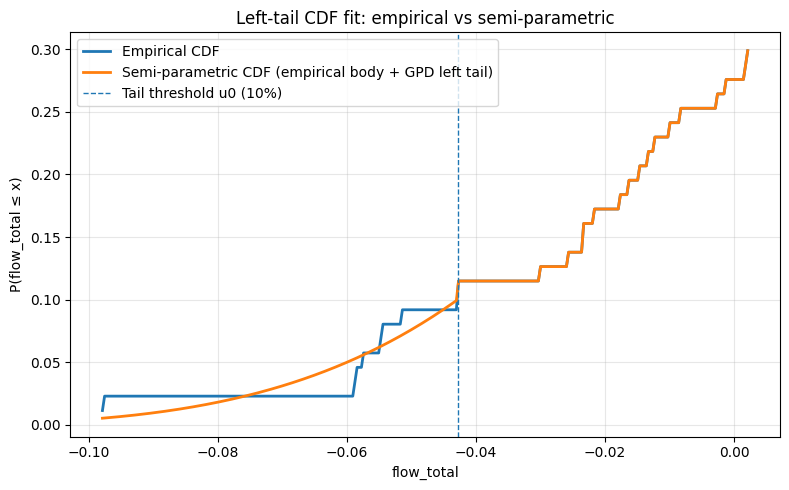

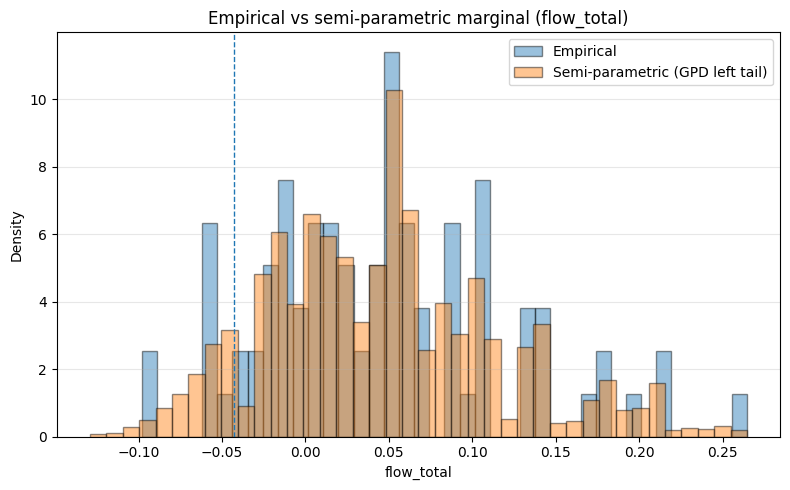

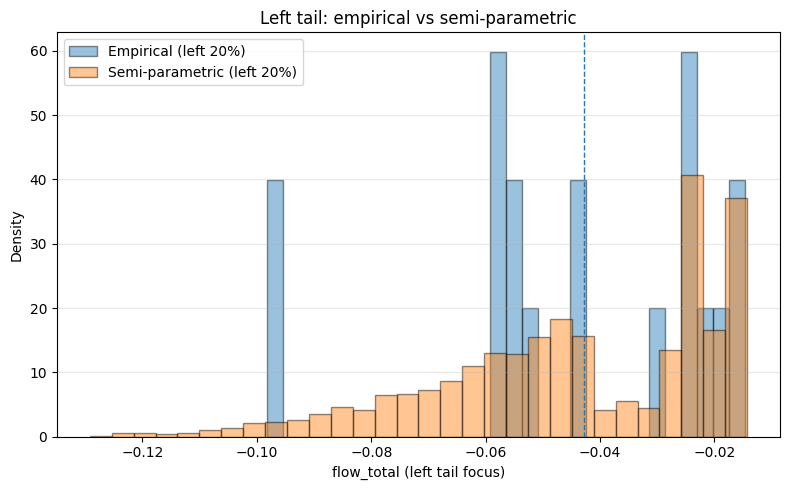

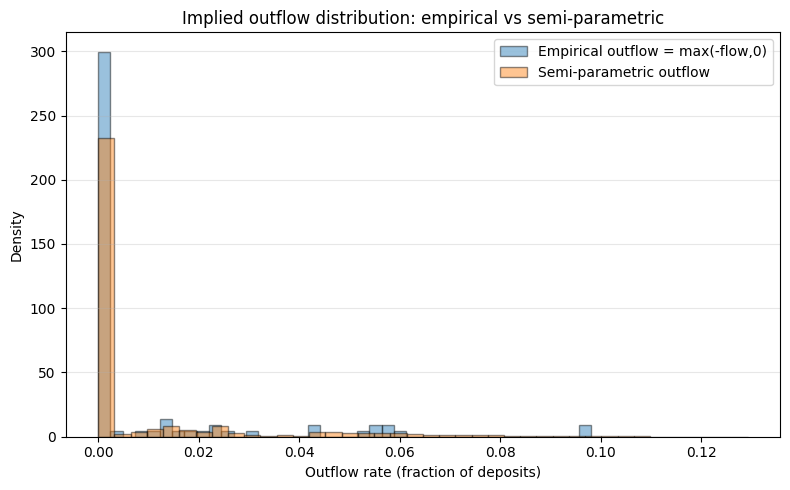

In [53]:
# ============================================
# 0) Data: quarterly total deposit flow
# ============================================
x = panel["flow_total"].astype(float).replace([np.inf, -np.inf], np.nan).dropna().to_numpy()
x = np.sort(x)
n = len(x)
print("n flow obs:", n)

# ============================================
# 1) Choose a left-tail threshold (POT)
#    Example: 10th percentile (tune this; try 5%, 10%, 15%)
# ============================================
p_tail = 0.10
u0 = np.quantile(x, p_tail)           # threshold in flow units (likely negative)
tail_mask = x <= u0
x_tail = x[tail_mask]

# Transform left tail to positive exceedances:
# z = u0 - x  (so bigger z = more negative flow)
z = (u0 - x_tail)
z = z[z > 0]  # should be all >0 except possible ties at threshold

print(f"Left-tail threshold u0 = {u0:.6f} (p_tail={p_tail:.2%}), tail n={len(z)}")

# ============================================
# 2) Fit GPD to exceedances z (support z>0)
#    GPD parameters: shape xi, scale beta
# ============================================
# Force loc=0 so z ~ GPD(xi, scale=beta) on [0,∞)
xi_hat, loc_hat, beta_hat = stats.genpareto.fit(z, floc=0)
print(f"GPD fit on z=u0-x: xi={xi_hat:.4f}, beta={beta_hat:.6f}")

# Tail probability mass
p0 = p_tail

# ============================================
# 3) Define semi-parametric CDF F_hat(x)
#    - For x > u0: empirical CDF on full sample
#    - For x <= u0: p0 * (1 - GPD_CDF(u0-x))
# ============================================
def F_emp(val):
    # empirical CDF with plotting-position smoothing
    # returns P(X <= val)
    return (np.searchsorted(x, val, side="right")) / n

def F_hat(val):
    val = np.asarray(val)
    out = np.empty_like(val, dtype=float)

    # body region
    body = val > u0
    out[body] = np.array([F_emp(v) for v in val[body]])

    # left tail region
    tail = ~body
    z_val = (u0 - val[tail])
    # GPD CDF on z>=0
    G = stats.genpareto.cdf(z_val, c=xi_hat, loc=0, scale=beta_hat)
    out[tail] = p0 * (1.0 - G)

    # clip for numerical safety
    eps = 1e-12
    return np.clip(out, eps, 1 - eps)

# ============================================
# 4) Define semi-parametric quantile Q_hat(u)
#    - For u > p0: empirical quantile on full sample
#    - For u <= p0: invert tail: z = GPD_PPF(1 - u/p0); x = u0 - z
# ============================================
def Q_emp(u):
    return np.quantile(x, u)

def Q_hat(u):
    u = np.asarray(u, dtype=float)
    out = np.empty_like(u, dtype=float)

    body = u > p0
    out[body] = np.array([Q_emp(ui) for ui in u[body]])

    tail = ~body
    # u = p0*(1-G)  => G = 1 - u/p0
    G_level = 1.0 - (u[tail] / p0)
    # invert GPD CDF for z
    z_q = stats.genpareto.ppf(G_level, c=xi_hat, loc=0, scale=beta_hat)
    out[tail] = u0 - z_q

    return out

# ============================================
# 5) Visual diagnostics
#    (A) Left-tail CDF: empirical vs semi-parametric
# ============================================
grid = np.linspace(np.quantile(x, 0.01), np.quantile(x, 0.30), 300)
F_emp_grid = np.array([F_emp(g) for g in grid])
F_hat_grid = F_hat(grid)

plt.figure(figsize=(8, 5))
plt.plot(grid, F_emp_grid, label="Empirical CDF", linewidth=2)
plt.plot(grid, F_hat_grid, label="Semi-parametric CDF (empirical body + GPD left tail)", linewidth=2)
plt.axvline(u0, linestyle="--", linewidth=1, label=f"Tail threshold u0 ({p_tail:.0%})")
plt.xlabel("flow_total")
plt.ylabel("P(flow_total ≤ x)")
plt.title("Left-tail CDF fit: empirical vs semi-parametric")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================
# 6) Compare empirical vs semi-parametric simulated flows
# ============================================
m = 20000
u_sim = np.random.default_rng(0).uniform(size=m)
x_semi = Q_hat(u_sim)

plt.figure(figsize=(8, 5))
plt.hist(x, bins=40, density=True, alpha=0.45, edgecolor="black", label="Empirical")
plt.hist(x_semi, bins=40, density=True, alpha=0.45, edgecolor="black", label="Semi-parametric (GPD left tail)")
plt.axvline(u0, linestyle="--", linewidth=1)
plt.xlabel("flow_total")
plt.ylabel("Density")
plt.title("Empirical vs semi-parametric marginal (flow_total)")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================
# 7) Tail-focused comparison (more readable)
# ============================================
plt.figure(figsize=(8, 5))
plt.hist(x[x <= np.quantile(x, 0.20)], bins=30, density=True, alpha=0.45, edgecolor="black", label="Empirical (left 20%)")
plt.hist(x_semi[x_semi <= np.quantile(x_semi, 0.20)], bins=30, density=True, alpha=0.45, edgecolor="black", label="Semi-parametric (left 20%)")
plt.axvline(u0, linestyle="--", linewidth=1)
plt.xlabel("flow_total (left tail focus)")
plt.ylabel("Density")
plt.title("Left tail: empirical vs semi-parametric")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: translate to outflows (one-sided) and view tail
out_emp = np.maximum(-x, 0.0)
out_semi = np.maximum(-x_semi, 0.0)

plt.figure(figsize=(8, 5))
plt.hist(out_emp, bins=40, density=True, alpha=0.45, edgecolor="black", label="Empirical outflow = max(-flow,0)")
plt.hist(out_semi, bins=40, density=True, alpha=0.45, edgecolor="black", label="Semi-parametric outflow")
plt.xlabel("Outflow rate (fraction of deposits)")
plt.ylabel("Density")
plt.title("Implied outflow distribution: empirical vs semi-parametric")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

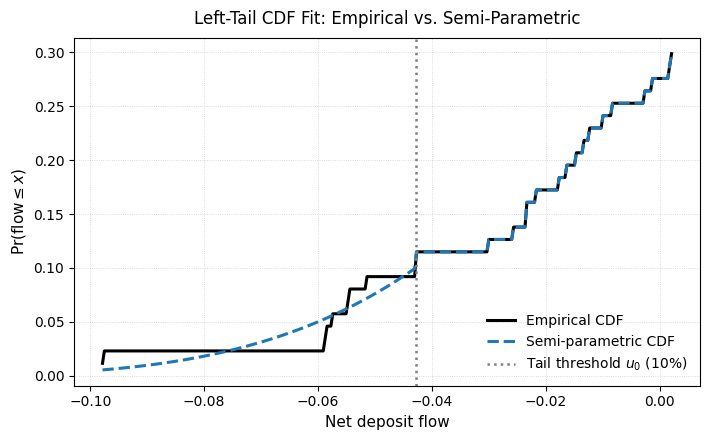

In [54]:
plt.figure(figsize=(7.2, 4.5))
plt.plot(
    grid, F_emp_grid,
    label="Empirical CDF",
    color="black",
    linewidth=2.2,
    linestyle="-"
)

plt.plot(
    grid, F_hat_grid,
    label="Semi-parametric CDF",
    color="tab:blue",
    linewidth=2.2,
    linestyle="--"
)

plt.axvline(
    u0,
    color="gray",
    linestyle=":",
    linewidth=1.8,
    label=fr"Tail threshold $u_0$ ({int(p_tail*100)}%)"
)

plt.xlabel("Net deposit flow", fontsize=11)
plt.ylabel(r"$\Pr(\mathrm{flow} \leq x)$", fontsize=11)

plt.title(
    "Left-Tail CDF Fit: Empirical vs. Semi-Parametric",
    fontsize=12,
    pad=10
)

plt.legend(
    frameon=False,
    fontsize=10,
    loc="lower right"
)

plt.grid(
    which="major",
    linestyle=":",
    linewidth=0.6,
    alpha=0.6
)

plt.tick_params(axis="both", labelsize=10)
plt.tight_layout()
plt.show()

## Full t-copula + Vasicek-on-panel + semi-parametric Log deposit-flow tail Model

Vasicek fit (quarterly levels, decimals):
  n=86, R²=0.8975, phi=0.952132
  r0=4.3300%, a=0.1962, b=1.4474%, sigma=1.0393%
n obs (copula fit): 86
rho_t_hat (from latent t): -0.3273599351872017
Shock fixed at +100 bps => Δr*=+1.0000%, u_y_star=0.9875757351, t_y_star=2.637
D0 (domestic deposits): 161.5 bn, HQLA: 49.8 bn
Left-tail GPD fit (on log deposit flow):
  threshold u        = -0.0100273
  tail mass p_tail   = 0.233
  xi_hat (shape)     = -0.235
  beta_hat (scale)   = 0.033949


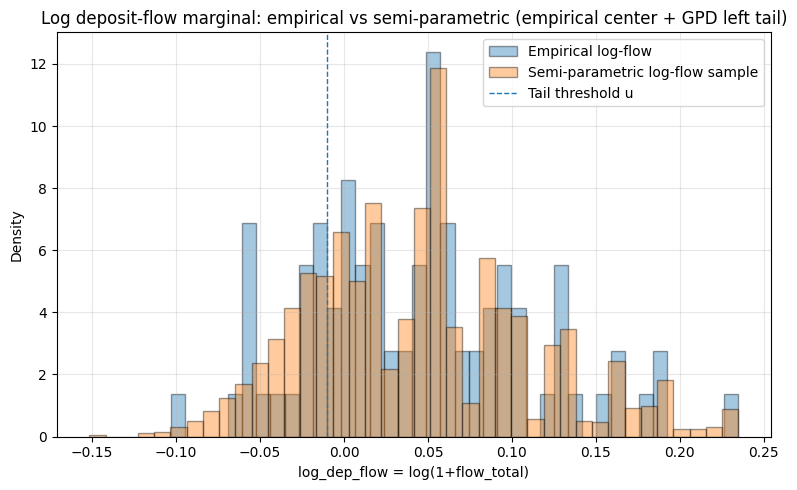

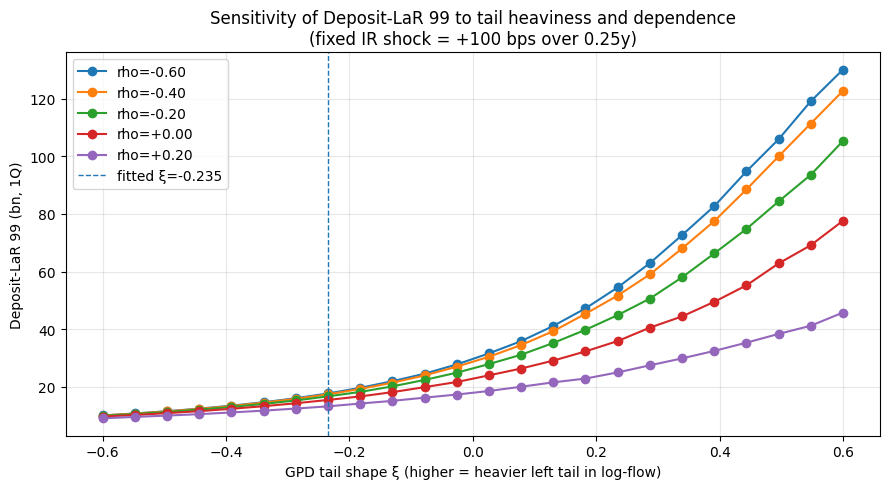

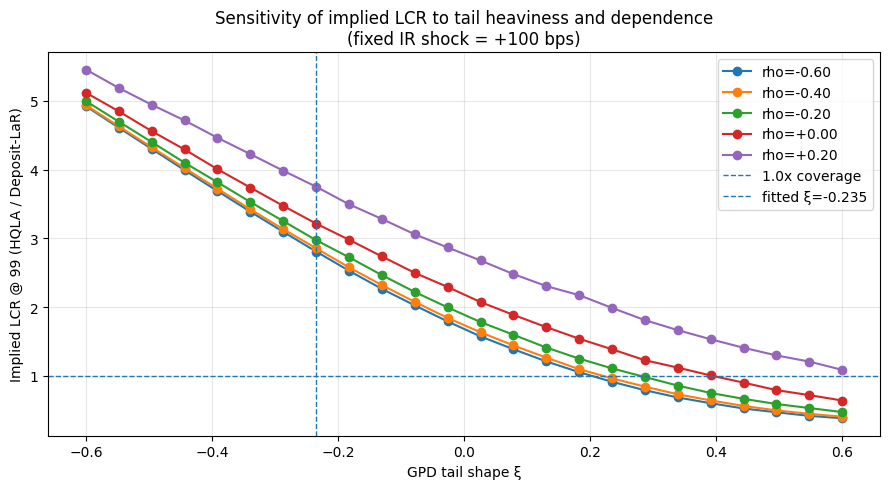

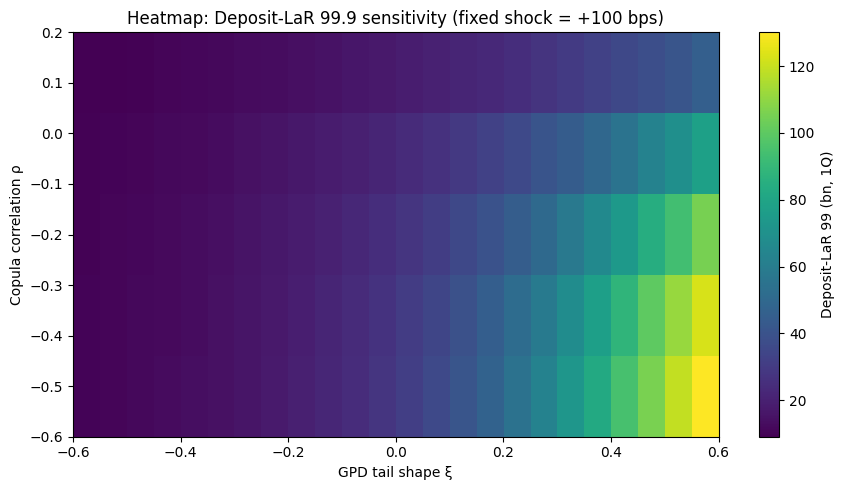

In [ ]:
# =========================================================
# Self-contained script: t-copula + Vasicek-on-panel + semi-parametric LOG deposit-flow tail
#
# Assumptions:
#   - `panel` already exists in memory as a pandas DataFrame
#   - panel has (at minimum) these columns:
#       report_date (datetime-like or parseable)
#       flow_total                      (deposit % change, i.e. (D1-D0)/D0)
#       fed_funds                       (decimal)
#       total_deposits_domestic         (thousands)
#       cash_and_balances               (thousands)
#       interest_bearing_balances       (thousands)
#       securities_afs_total            (thousands)
#
# Notes:
#   - We work in log deposit flow: z = log(1 + flow_total) = log(D1/D0)
#   - Copula X is z (log flow), Y is Δr (quarterly change in decimal rate)
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

# =========================================================
# 0) USER KNOBS
# =========================================================
num_sim = 500_000
nu = 10                         # t-copula df
T_horizon = 0.25                # quarter horizon
shock_bps_fixed = 100          # scenario: force Δr = shock over the horizon

alpha_99  = 0.99
alpha_999 = 0.999

# Sensitivity grids
xi_grid  = np.linspace(-0.6, 0.6, 24)                 # tail heaviness (GPD shape)
rho_grid = np.array([-0.60, -0.40, -0.20, 0.00, 0.20])  # dependence sensitivity

rng = np.random.default_rng(42)
eps = 1e-8

# =========================================================
# 1) Helpers: Vasicek fit and marginal
# =========================================================
def fit_vasicek_from_ar1(r_series: pd.Series, delta_years: float):
    """
    Fit OU/Vasicek via discrete AR(1):
      r_{t+Δ} = c + φ r_t + ε
    where:
      φ = exp(-aΔ)
      c = b (1-φ)
      Var(ε) = σ^2/(2a) * (1-φ^2)

    Inputs:
      r_series: rate level series in DECIMAL units (e.g., 0.053 for 5.3%)
      delta_years: time step in years (quarterly => 0.25)

    Returns:
      r0, a, b, sigma, diagnostics dict
    """
    r = r_series.dropna().astype(float)
    if len(r) < 20:
        raise ValueError(f"Not enough observations to fit Vasicek (got {len(r)}).")

    r_t   = r.shift(1).dropna()
    r_tp1 = r.loc[r_t.index]

    X = sm.add_constant(r_t.values)
    y = r_tp1.values
    model = sm.OLS(y, X).fit()

    c   = float(model.params[0])
    phi = float(model.params[1])
    s2  = float(model.mse_resid)

    # Guardrails
    phi = float(np.clip(phi, 1e-6, 0.999999))

    a = -np.log(phi) / delta_years
    b = c / (1.0 - phi)

    # Discrete OU mapping (no extra /delta)
    sigma2 = s2 * (2.0 * a) / (1.0 - phi**2)
    sigma  = float(np.sqrt(max(sigma2, 0.0)))

    r0 = float(r.iloc[-1])

    diag = {
        "c": c,
        "phi": phi,
        "resid_var": s2,
        "r2": float(model.rsquared),
        "n": int(model.nobs),
    }
    return r0, float(a), float(b), sigma, diag


def vasicek_marginal_params(r0, a, b, sigma, T):
    """r_T | r0 ~ N(m_T, v_T)"""
    m_T = b + (r0 - b) * np.exp(-a * T)
    v_T = sigma**2 / (2.0 * a) * (1.0 - np.exp(-2.0 * a * T))
    return m_T, np.sqrt(v_T)

# =========================================================
# 2) Helpers: t-copula conditional sampler
# =========================================================
def sample_t_conditional_x_given_y(ty, rho, nu, size, rng):
    """
    (Tx,Ty) ~ t_nu(0, [[1,rho],[rho,1]])
    => Tx | Ty=ty is t_{nu+1} with:
       mean = rho*ty
       scale^2 = ((nu + ty^2)/(nu+1)) * (1 - rho^2)
    """
    df_cond = nu + 1
    mu_cond = rho * ty
    scale2  = ((nu + ty**2) / (nu + 1.0)) * (1.0 - rho**2)
    scale   = np.sqrt(scale2)

    z = rng.standard_t(df_cond, size=size)
    return mu_cond + scale * z

# =========================================================
# 3) Helpers: semi-parametric marginal (empirical center + GPD LEFT tail)
#    Here X is LOG deposit flow: z = log(1+flow)
# =========================================================
def fit_left_tail_gpd(x, tail_q=0.10, min_tail=20):
    """
    Robust left-tail GPD fit with a minimum number of tail points.

    - Chooses k = max(ceil(tail_q*n), min_tail) smallest observations as tail
      (robust to ties causing too few x<u).
    - Sets threshold u slightly ABOVE the k-th smallest so tail is x<u with >=k points.
    """
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    n = len(x)
    if n < (min_tail + 5):
        raise ValueError(f"Not enough data to fit GPD: n={n}, min_tail={min_tail}")

    x_sorted = np.sort(x)

    k = max(int(np.ceil(tail_q * n)), int(min_tail))
    k = min(k, n - 5)

    u_k = x_sorted[k - 1]
    u = u_k + 1e-12  # ensure strict x<u includes ties

    tail = x[x < u]
    if len(tail) < min_tail:
        for kk in range(k + 1, n - 4):
            u = x_sorted[kk - 1] + 1e-12
            tail = x[x < u]
            if len(tail) >= min_tail:
                k = kk
                break

    if len(tail) < min_tail:
        raise ValueError(f"Too few tail points after tie-handling (got {len(tail)}).")

    p_tail = float(len(tail) / n)

    L = (u - tail)                 # exceedances (positive)
    L = np.clip(L, 1e-12, None)    # avoid exact zeros

    xi_hat, _, beta_hat = stats.genpareto.fit(L, floc=0)
    return float(u), float(p_tail), float(xi_hat), float(beta_hat)


def semi_parametric_quantile_lefttail(u, x_sorted, p_grid, u_thresh, p_tail, xi, beta):
    """
    Map uniforms u in (0,1) to X:
      - if u <= p_tail: use GPD left-tail (below u_thresh)
      - else: empirical quantile via interpolation on sorted sample
    Ensures continuity at u=p_tail (returns u_thresh).
    """
    u = np.asarray(u)
    out = np.empty_like(u, dtype=float)

    mask_center = (u > p_tail)
    if np.any(mask_center):
        out[mask_center] = np.interp(u[mask_center], p_grid, x_sorted)

    mask_tail = ~mask_center
    if np.any(mask_tail):
        v = np.clip(u[mask_tail] / max(p_tail, eps), eps, 1 - eps)
        qL = stats.genpareto.ppf(1.0 - v, c=xi, loc=0.0, scale=beta)
        out[mask_tail] = u_thresh - qL

    return out

# =========================================================
# 4) Preconditions + panel prep (no API calls)
# =========================================================
required_cols = [
    "report_date", "flow_total", "fed_funds",
    "total_deposits_domestic", "cash_and_balances",
    "interest_bearing_balances", "securities_afs_total"
]
missing = [c for c in required_cols if c not in panel.columns]
if missing:
    raise KeyError(f"`panel` is missing required columns: {missing}")

panel = panel.copy()
panel["report_date"] = pd.to_datetime(panel["report_date"])
panel = panel.sort_values("report_date")

# Validate and build log deposit flow: z = log(1+flow_total)
panel["flow_total"] = panel["flow_total"].astype(float)
if (panel["flow_total"] <= -1.0).any():
    bad_n = int((panel["flow_total"] <= -1.0).sum())
    raise ValueError(f"flow_total has {bad_n} values <= -1.0; cannot form log1p. Fix data definition/quality.")
panel["log_dep_flow"] = np.log1p(panel["flow_total"])

# Convert fed funds level (%) -> decimal level
panel["fed_funds_dec"] = panel["fed_funds"].astype(float)

# Quarterly change in fed funds (decimal change, consistent with bps/10_000 shocks)
panel["fedfunds_change"] = panel["fed_funds_dec"].diff()

# =========================================================
# 5) Fit Vasicek on quarterly level series from panel
# =========================================================
r_q = panel.set_index("report_date")["fed_funds_dec"].dropna()
delta_years = 0.25

r0, a, b, sigma, vas_diag = fit_vasicek_from_ar1(r_q, delta_years)

print("Vasicek fit (quarterly levels, decimals):")
print(f"  n={vas_diag['n']}, R²={vas_diag['r2']:.4f}, phi={vas_diag['phi']:.6f}")
print(f"  r0={r0:.4%}, a={a:.4f}, b={b:.4%}, sigma={sigma:.4%}")

# =========================================================
# 6) Data for copula fit (X = log_dep_flow, Y = fedfunds_change)
# =========================================================
df = panel[["log_dep_flow", "fedfunds_change"]].dropna().copy()
x_hist = df["log_dep_flow"].to_numpy(dtype=float)     # X is log flow
y_hist = df["fedfunds_change"].to_numpy(dtype=float)  # Y is Δr
n = len(df)
print("n obs (copula fit):", n)

if n < 30:
    raise ValueError(f"Too few observations for copula fit (n={n}).")

# Rank uniforms
u_x = (stats.rankdata(x_hist, method="average") - 0.5) / n
u_y = (stats.rankdata(y_hist, method="average") - 0.5) / n
u_x = np.clip(u_x, eps, 1 - eps)
u_y = np.clip(u_y, eps, 1 - eps)

# Latent t variates and base rho_t estimate
t_x = stats.t.ppf(u_x, df=nu)
t_y = stats.t.ppf(u_y, df=nu)
rho_t_hat = float(np.corrcoef(t_x, t_y)[0, 1])
print("rho_t_hat (from latent t):", rho_t_hat)

# =========================================================
# 7) Scenario: condition on Δr = shock over horizon (consistent with y_hist)
# =========================================================
m_T, std_T = vasicek_marginal_params(r0, a, b, sigma, T_horizon)

# Δr distribution under Vasicek: Δr = r_T - r0 ~ N(m_T - r0, std_T^2)
mu_d = m_T - r0
sd_d = std_T

delta_star = shock_bps_fixed / 10_000.0  # decimal change
u_y_star = stats.norm.cdf(delta_star, loc=mu_d, scale=sd_d)
u_y_star = float(np.clip(u_y_star, eps, 1 - eps))
t_y_star = float(stats.t.ppf(u_y_star, df=nu))

print(f"Shock fixed at {shock_bps_fixed:+.0f} bps => Δr*={delta_star:+.4%}, u_y_star={u_y_star:.10f}, t_y_star={t_y_star:.3f}")

# =========================================================
# 8) Balance sheet snapshot + HQLA (billions)
# =========================================================
latest = panel.iloc[-1]
D0_th = float(latest["total_deposits_domestic"])  # thousands

HQLA_th = (
    float(latest["cash_and_balances"])
    + float(latest["interest_bearing_balances"])
    + float(latest["securities_afs_total"])
)

HQLA_bn = HQLA_th / 1e6
D0_bn = D0_th / 1e6
print(f"D0 (domestic deposits): {D0_bn:.1f} bn, HQLA: {HQLA_bn:.1f} bn")

# =========================================================
# 9) Semi-parametric marginal fit on X (log deposit flow)
# =========================================================
u_thresh, p_tail, xi_hat, beta_hat = fit_left_tail_gpd(x_hist, tail_q=0.10, min_tail=20)
print("Left-tail GPD fit (on log deposit flow):")
print(f"  threshold u        = {u_thresh:.6g}")
print(f"  tail mass p_tail   = {p_tail:.3f}")
print(f"  xi_hat (shape)     = {xi_hat:.3f}")
print(f"  beta_hat (scale)   = {beta_hat:.6g}")

# Pre-sort once for fast empirical quantiles
x_sorted = np.sort(x_hist)
n_x = len(x_sorted)
p_grid = (np.arange(n_x) + 0.5) / n_x

# Optional visual check: compare empirical log-flow vs semi-parametric draws
u_grid = np.linspace(eps, 1 - eps, 2000)
x_sp_base = semi_parametric_quantile_lefttail(u_grid, x_sorted, p_grid, u_thresh, p_tail, xi_hat, beta_hat)

plt.figure(figsize=(8, 5))
plt.hist(x_hist, bins=40, density=True, alpha=0.4, edgecolor="black", label="Empirical log-flow")
plt.hist(x_sp_base, bins=40, density=True, alpha=0.4, edgecolor="black", label="Semi-parametric log-flow sample")
plt.axvline(u_thresh, linestyle="--", linewidth=1, label="Tail threshold u")
plt.title("Log deposit-flow marginal: empirical vs semi-parametric (empirical center + GPD left tail)")
plt.xlabel("log_dep_flow = log(1+flow_total)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =========================================================
# 10) Sensitivity loop over (xi, rho)
# =========================================================
LaR99  = np.zeros((len(rho_grid), len(xi_grid)))
LaR999 = np.zeros((len(rho_grid), len(xi_grid)))
LCR99  = np.zeros((len(rho_grid), len(xi_grid)))
LCR999 = np.zeros((len(rho_grid), len(xi_grid)))

for i_r, rho in enumerate(rho_grid):
    for j_xi, xi in enumerate(xi_grid):

        # 1) Conditional latent Tx | Ty=t_y_star under rho
        t_x_cond = sample_t_conditional_x_given_y(t_y_star, rho, nu, num_sim, rng)

        # 2) Back to uniform via marginal t CDF
        u_x_cond = stats.t.cdf(t_x_cond, df=nu)
        u_x_cond = np.clip(u_x_cond, eps, 1 - eps)

        # 3) Map uniforms -> log deposit flow via semi-parametric marginal (xi override)
        logflow_sim = semi_parametric_quantile_lefttail(
            u_x_cond, x_sorted, p_grid,
            u_thresh=u_thresh, p_tail=p_tail,
            xi=xi, beta=beta_hat
        )

        # 4) Convert log flow -> deposits at horizon:
        #    logflow = log(D1/D0) => D1 = D0 * exp(logflow)
        D1_th = D0_th * np.exp(logflow_sim)

        # Outflow over horizon (thousands)
        outflow_th = np.maximum(D0_th - D1_th, 0.0)
        outflow_bn = outflow_th / 1e6

        lar99  = float(np.quantile(outflow_bn, alpha_99))
        lar999 = float(np.quantile(outflow_bn, alpha_999))

        LaR99[i_r, j_xi]  = lar99
        LaR999[i_r, j_xi] = lar999
        LCR99[i_r, j_xi]  = HQLA_bn / lar99  if lar99  > 0 else np.inf
        LCR999[i_r, j_xi] = HQLA_bn / lar999 if lar999 > 0 else np.inf

# =========================================================
# 11) Visualizations
# =========================================================

# (A) Lines: LaR99 vs xi, separate lines for rho
plt.figure(figsize=(9, 5))
for i_r, rho in enumerate(rho_grid):
    plt.plot(xi_grid, LaR99[i_r, :], marker="o", label=f"rho={rho:+.2f}")
plt.xlabel("GPD tail shape ξ (higher = heavier left tail in log-flow)")
plt.ylabel("Deposit-LaR 99 (bn, 1Q)")
plt.title(f"Sensitivity of Deposit-LaR 99 to tail heaviness and dependence\n(fixed IR shock = {shock_bps_fixed:+.0f} bps over {T_horizon}y)")
plt.axvline(xi_hat, linestyle="--", linewidth=1, label=f"fitted ξ={xi_hat:.3f}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# (B) Lines: Implied LCR@99 vs xi
plt.figure(figsize=(9, 5))
for i_r, rho in enumerate(rho_grid):
    plt.plot(xi_grid, LCR99[i_r, :], marker="o", label=f"rho={rho:+.2f}")
plt.axhline(1.0, linestyle="--", linewidth=1, label="1.0x coverage")
plt.xlabel("GPD tail shape ξ")
plt.ylabel("Implied LCR @ 99 (HQLA / Deposit-LaR)")
plt.title(f"Sensitivity of implied LCR to tail heaviness and dependence\n(fixed IR shock = {shock_bps_fixed:+.0f} bps)")
plt.axvline(xi_hat, linestyle="--", linewidth=1, label=f"fitted ξ={xi_hat:.3f}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# (C) Heatmap: LaR99
plt.figure(figsize=(9, 5))
plt.imshow(
    LaR99,
    aspect="auto",
    origin="lower",
    extent=[xi_grid.min(), xi_grid.max(), rho_grid.min(), rho_grid.max()],
)
plt.colorbar(label="Deposit-LaR 99 (bn, 1Q)")
plt.xlabel("GPD tail shape ξ")
plt.ylabel("Copula correlation ρ")
plt.title(f"Heatmap: Deposit-LaR 99.9 sensitivity (fixed shock = {shock_bps_fixed:+.0f} bps)")
plt.tight_layout()
plt.show()

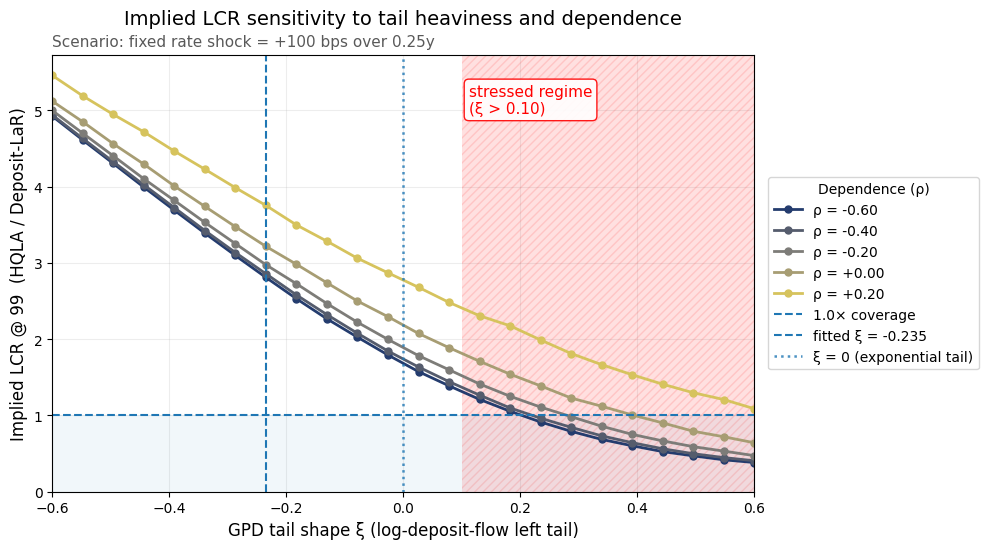

In [60]:
# (B) Lines: Implied LCR@99 vs xi (beautified + stress regime highlight)
fig, ax = plt.subplots(figsize=(10, 5.6))

cmap = plt.get_cmap("cividis")  # or "viridis", "magma", "Greys"
colors = [cmap(v) for v in np.linspace(0.15, 0.85, len(rho_grid))]

# Plot lines
for i_r, rho in enumerate(rho_grid):
    ax.plot(
        xi_grid, LCR99[i_r, :],
        color=colors[i_r],
        marker="o", markersize=5, linewidth=2,
        label=f"ρ = {rho:+.2f}"
    )

# Coverage threshold
ax.axhline(1.0, linestyle="--", linewidth=1.5, label="1.0× coverage")

# Fitted xi marker
ax.axvline(xi_hat, linestyle="--", linewidth=1.5, label=f"fitted ξ = {xi_hat:.3f}")

# Stress regime highlight: xi > 0.10
stress_cut = 0.10
ax.axvspan(stress_cut, xi_grid.max(), alpha=0.12, hatch="////",
           edgecolor="red", facecolor="red", linewidth=0.0)

# Label for stress regime (placed near top-right)
ymax = np.nanmax(LCR99) if np.isfinite(LCR99).any() else 1.0
ax.text(
    stress_cut + 0.01*(xi_grid.max() - xi_grid.min()),
    0.98 * ymax,
    "stressed regime\n(ξ > 0.10)",
    color="red",
    fontsize=11,
    va="top",
    ha="left",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="red", alpha=0.9)
)

# Optional: highlight breach zone (LCR < 1)
ax.axhspan(0, 1.0, alpha=0.06)

# Axes labels / title
ax.set_xlabel("GPD tail shape ξ (log-deposit-flow left tail)", fontsize=12)
ax.set_ylabel("Implied LCR @ 99  (HQLA / Deposit-LaR)", fontsize=12)

ax.set_title(
    "Implied LCR sensitivity to tail heaviness and dependence",
    fontsize=14, pad=22
)
ax.text(
    0.0, 1.02,
    f"Scenario: fixed rate shock = {shock_bps_fixed:+.0f} bps over {T_horizon:.2f}y",
    transform=ax.transAxes,
    fontsize=11,
    color="0.35"
)

ax.axvline(0.0, linestyle=":", linewidth=1.8, alpha=0.8, label="ξ = 0 (exponential tail)")

# Cosmetics
ax.grid(True, which="major", alpha=0.22)
ax.set_axisbelow(True)

# Nice limits (keep some headroom)
ax.set_xlim(xi_grid.min(), xi_grid.max())
ax.set_ylim(bottom=0)

# Legend outside
ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True,
    borderaxespad=0.0,
    title="Dependence (ρ)"
)

plt.tight_layout()
plt.show()

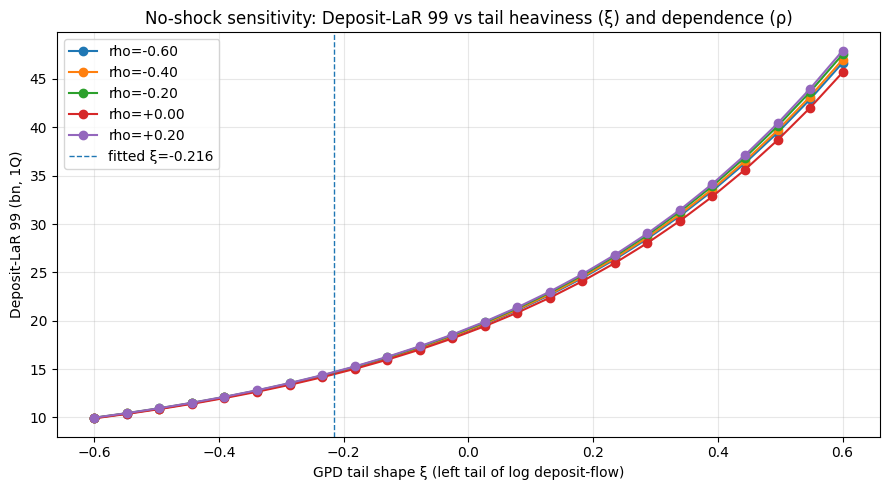

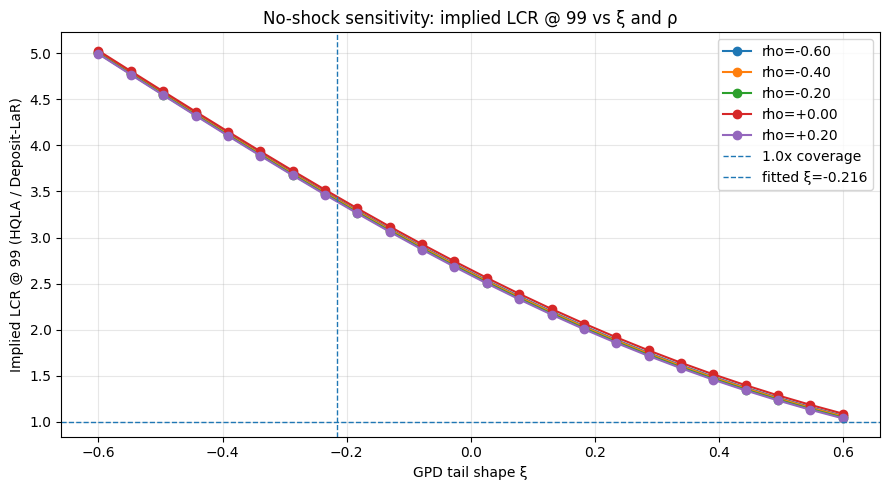

In [67]:
# -----------------------
# Setup
# -----------------------
num_sim   = 200_000
nu        = 10
alpha_99  = 0.99
tail_q    = 0.10
min_tail  = 20

xi_grid  = np.linspace(-0.6, 0.6, 24)
rho_grid = np.array([-0.60, -0.40, -0.20, 0.00, 0.20])

rng = np.random.default_rng(42)
eps = 1e-10

# -----------------------
# Require panel + columns
# -----------------------
panel = panel.copy()
panel["report_date"] = pd.to_datetime(panel["report_date"])
panel = panel.sort_values("report_date")

# X = log deposit flow
x_hist = np.log1p(panel["flow_total"].astype(float).replace([np.inf, -np.inf], np.nan)).dropna().to_numpy()
if np.any(~np.isfinite(x_hist)):
    raise ValueError("Non-finite log flows found after log1p.")

# Latest balance sheet snapshot
latest = panel.iloc[-1]
D0_th = float(latest["total_deposits_domestic"])  # thousands
HQLA_th = (float(latest["cash_and_balances"])
           + float(latest["interest_bearing_balances"])
           + float(latest["securities_afs_total"]))
HQLA_bn = HQLA_th / 1e6

# -----------------------
# Semi-parametric left-tail GPD fit on X
# -----------------------
def fit_left_tail_gpd(x, tail_q=0.10, min_tail=20):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = len(x)
    if n < (min_tail + 5):
        raise ValueError(f"Not enough data for GPD: n={n}")

    xs = np.sort(x)
    k = max(int(np.ceil(tail_q * n)), int(min_tail))
    k = min(k, n - 5)

    u = xs[k - 1] + 1e-12
    tail = x[x < u]
    # tie-handling if needed
    if len(tail) < min_tail:
        for kk in range(k + 1, n - 4):
            u = xs[kk - 1] + 1e-12
            tail = x[x < u]
            if len(tail) >= min_tail:
                break
    if len(tail) < min_tail:
        raise ValueError(f"Too few tail points after tie-handling (got {len(tail)}).")

    p_tail = float(len(tail) / n)
    L = np.clip(u - tail, 1e-12, None)  # exceedances > 0
    xi_hat, _, beta_hat = stats.genpareto.fit(L, floc=0)
    return float(u), float(p_tail), float(xi_hat), float(beta_hat)

def sp_quantile_lefttail(u, x_sorted, p_grid, u_thresh, p_tail, xi, beta):
    u = np.asarray(u, dtype=float)
    out = np.empty_like(u)

    center = (u > p_tail)
    if np.any(center):
        out[center] = np.interp(u[center], p_grid, x_sorted)

    tail = ~center
    if np.any(tail):
        v = np.clip(u[tail] / max(p_tail, eps), eps, 1 - eps)
        qL = stats.genpareto.ppf(1.0 - v, c=xi, loc=0.0, scale=beta)
        out[tail] = u_thresh - qL
    return out

u_thresh, p_tail, xi_hat, beta_hat = fit_left_tail_gpd(x_hist, tail_q=tail_q, min_tail=min_tail)

x_sorted = np.sort(x_hist)
n_x = len(x_sorted)
p_grid = (np.arange(n_x) + 0.5) / n_x

# -----------------------
# Unconditional t-copula draws for u_x (no shock)
# -----------------------
def draw_u_x_tcopula(rho, nu, size, rng):
    # multivariate t via: z~N(0,Sigma), w~chi2(nu), t=z/sqrt(w/nu)
    Sigma = np.array([[1.0, rho], [rho, 1.0]])
    L = np.linalg.cholesky(Sigma)

    z = rng.standard_normal((size, 2)) @ L.T
    w = rng.chisquare(df=nu, size=size)
    t = z / np.sqrt(w / nu)[:, None]

    u_x = stats.t.cdf(t[:, 0], df=nu)
    return np.clip(u_x, eps, 1 - eps)

# -----------------------
# Sensitivity: LaR99 vs xi for each rho (no shock)
# -----------------------
LaR99 = np.zeros((len(rho_grid), len(xi_grid)))
LCR99 = np.zeros((len(rho_grid), len(xi_grid)))

for i_r, rho in enumerate(rho_grid):
    u_x_sim = draw_u_x_tcopula(rho, nu, num_sim, rng)  # reuse across xi

    for j_xi, xi in enumerate(xi_grid):
        logflow_sim = sp_quantile_lefttail(
            u_x_sim, x_sorted, p_grid,
            u_thresh=u_thresh, p_tail=p_tail,
            xi=xi, beta=beta_hat
        )

        # Optional guardrail against absurd growth (keeps sim stable)
        logflow_sim = np.clip(logflow_sim, -5.0, 1.0)

        D1_th = D0_th * np.exp(logflow_sim)
        outflow_bn = np.maximum(D0_th - D1_th, 0.0) / 1e6

        lar = float(np.quantile(outflow_bn, alpha_99))
        LaR99[i_r, j_xi] = lar
        LCR99[i_r, j_xi] = HQLA_bn / lar if lar > 0 else np.inf

# -----------------------
# Plot: LaR99 vs xi, lines for rho
# -----------------------
plt.figure(figsize=(9, 5))
for i_r, rho in enumerate(rho_grid):
    plt.plot(xi_grid, LaR99[i_r, :], marker="o", label=f"rho={rho:+.2f}")
plt.axvline(xi_hat, linestyle="--", linewidth=1, label=f"fitted ξ={xi_hat:.3f}")
plt.xlabel("GPD tail shape ξ (left tail of log deposit-flow)")
plt.ylabel("Deposit-LaR 99 (bn, 1Q)")
plt.title("No-shock sensitivity: Deposit-LaR 99 vs tail heaviness (ξ) and dependence (ρ)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# (Optional) Plot: implied LCR@99 vs xi
plt.figure(figsize=(9, 5))
for i_r, rho in enumerate(rho_grid):
    plt.plot(xi_grid, LCR99[i_r, :], marker="o", label=f"rho={rho:+.2f}")
plt.axhline(1.0, linestyle="--", linewidth=1, label="1.0x coverage")
plt.axvline(xi_hat, linestyle="--", linewidth=1, label=f"fitted ξ={xi_hat:.3f}")
plt.xlabel("GPD tail shape ξ")
plt.ylabel("Implied LCR @ 99 (HQLA / Deposit-LaR)")
plt.title("No-shock sensitivity: implied LCR @ 99 vs ξ and ρ")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

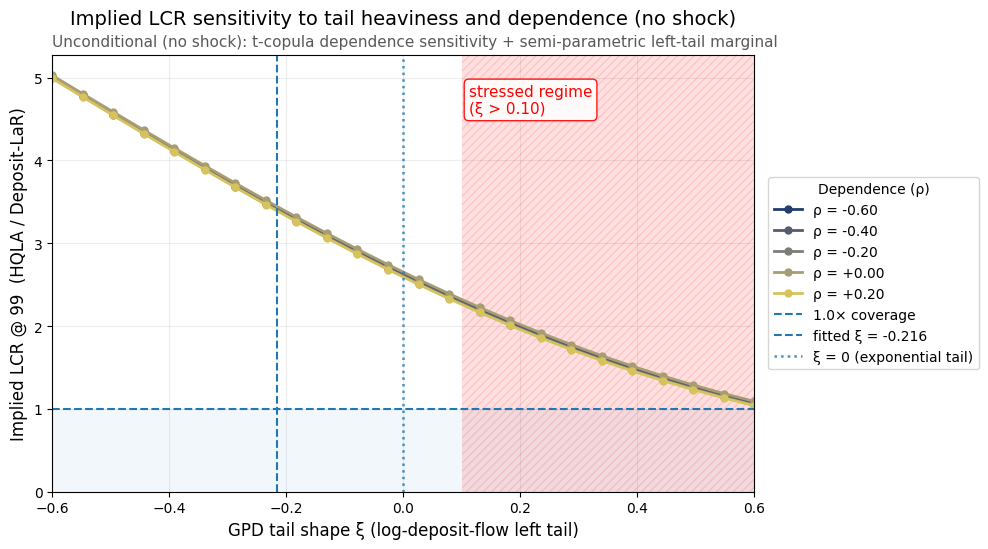

In [68]:
# (B) Lines: Implied LCR@99 vs xi (beautified + stress regime highlight) — NO SHOCK
fig, ax = plt.subplots(figsize=(10, 5.6))

cmap = plt.get_cmap("cividis")
colors = [cmap(v) for v in np.linspace(0.15, 0.85, len(rho_grid))]

# Plot lines
for i_r, rho in enumerate(rho_grid):
    ax.plot(
        xi_grid, LCR99[i_r, :],
        color=colors[i_r],
        marker="o", markersize=5, linewidth=2,
        label=f"ρ = {rho:+.2f}"
    )

# Coverage threshold
ax.axhline(1.0, linestyle="--", linewidth=1.5, label="1.0× coverage")

# Fitted xi marker
ax.axvline(xi_hat, linestyle="--", linewidth=1.5, label=f"fitted ξ = {xi_hat:.3f}")

# Stress regime highlight: xi > 0.10
stress_cut = 0.10
ax.axvspan(
    stress_cut, xi_grid.max(),
    alpha=0.12, hatch="////",
    edgecolor="red", facecolor="red", linewidth=0.0
)

# Label for stress regime
ymax = np.nanmax(LCR99[np.isfinite(LCR99)]) if np.isfinite(LCR99).any() else 1.0
ax.text(
    stress_cut + 0.01 * (xi_grid.max() - xi_grid.min()),
    0.98 * ymax,
    "stressed regime\n(ξ > 0.10)",
    color="red",
    fontsize=11,
    va="top",
    ha="left",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="red", alpha=0.9)
)

# Optional: highlight breach zone (LCR < 1)
ax.axhspan(0, 1.0, alpha=0.06)

# Axes labels / title
ax.set_xlabel("GPD tail shape ξ (log-deposit-flow left tail)", fontsize=12)
ax.set_ylabel("Implied LCR @ 99  (HQLA / Deposit-LaR)", fontsize=12)

ax.set_title("Implied LCR sensitivity to tail heaviness and dependence (no shock)", fontsize=14, pad=22)
ax.text(
    0.0, 1.02,
    "Unconditional (no shock): t-copula dependence sensitivity + semi-parametric left-tail marginal",
    transform=ax.transAxes,
    fontsize=11,
    color="0.35"
)

# Reference line for xi=0
ax.axvline(0.0, linestyle=":", linewidth=1.8, alpha=0.8, label="ξ = 0 (exponential tail)")

# Cosmetics
ax.grid(True, which="major", alpha=0.22)
ax.set_axisbelow(True)
ax.set_xlim(xi_grid.min(), xi_grid.max())
ax.set_ylim(bottom=0)

# Legend outside
ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True,
    borderaxespad=0.0,
    title="Dependence (ρ)"
)

plt.tight_layout()
plt.show()

## Conditional Tests

In [65]:
# =========================================================
# Assumes you ALREADY have these from your earlier script:
#   - nu                         (t-copula df)
#   - mu_d, sd_d                 (Vasicek-implied Δr ~ N(mu_d, sd_d^2) over T_horizon)
#   - D0_th                      (starting deposits, thousands)
#   - x_sorted, p_grid           (sorted historical X sample + plotting positions)
#   - u_thresh, p_tail           (left-tail threshold + tail mass for X)
#   - xi_hat, beta_hat           (GPD params for left-tail exceedances on X)
#   - semi_parametric_quantile_lefttail(u, x_sorted, p_grid, u_thresh, p_tail, xi, beta)
# If you renamed X to log-flow, x_sorted should be your historical log-flow sample.
# =========================================================

# ---------- knobs for THIS plot ----------
alpha = 0.99
num_sim_cond = 200_000         # per (rho,k) cell; increase for smoother heatmap
eps = 1e-8
rng = np.random.default_rng(123)

# rho grid (rows)
rho_grid = np.array([-0.60, -0.40, -0.20, 0.00, 0.20, 0.40, 0.60])

# thresholds in bps (columns)
kmax_bps = 400
n_k = 31  # more columns => smoother
k_grid = np.linspace(-kmax_bps, kmax_bps, n_k)

# ---------------------------------------------------------
# Vectorized conditional sampler for Tx | Ty=ty (ty can be vector)
# ---------------------------------------------------------
def sample_tx_given_ty_vec(ty_vec, rho, nu, rng):
    """
    (Tx,Ty) ~ t_nu(0, [[1,rho],[rho,1]])
    Tx | Ty=ty is t_{nu+1} with:
      mean = rho*ty
      scale^2 = ((nu + ty^2)/(nu+1)) * (1 - rho^2)
    """
    ty = np.asarray(ty_vec, dtype=float)
    df_cond = nu + 1
    mu = rho * ty
    scale2 = ((nu + ty**2) / (nu + 1.0)) * (1.0 - rho**2)
    scale = np.sqrt(scale2)

    z = rng.standard_t(df_cond, size=ty.shape[0])
    return mu + scale * z

# ---------------------------------------------------------
# Core: LaR99 (bn) under event Δr >= k  OR  Δr <= k
# ---------------------------------------------------------
def lar99_given_event(rho, k_bps, side, n_sims, rng):
    """
    side = "ge" for Δr >= k_bps (k_bps should be >= 0)
    side = "le" for Δr <= k_bps (k_bps should be <= 0)
    """
    k_dec = k_bps / 10_000.0  # bps -> decimal

    # Map rate threshold to uniform under Vasicek Δr marginal
    u_k = stats.norm.cdf(k_dec, loc=mu_d, scale=sd_d)
    u_k = float(np.clip(u_k, eps, 1 - eps))

    # Sample Ty from *truncated* t marginal (conditional on the inequality event)
    if side == "ge":
        u = rng.uniform(u_k, 1 - eps, size=n_sims)
    elif side == "le":
        u = rng.uniform(eps, u_k, size=n_sims)
    else:
        raise ValueError("side must be 'ge' or 'le'")

    ty = stats.t.ppf(u, df=nu)

    # Sample Tx | Ty
    tx = sample_tx_given_ty_vec(ty, rho, nu, rng)

    # Tx -> Ux
    u_x = stats.t.cdf(tx, df=nu)
    u_x = np.clip(u_x, eps, 1 - eps)

    # Ux -> X via your semi-parametric marginal (X is log-flow if that's what you fitted)
    x_sim = semi_parametric_quantile_lefttail(
        u_x, x_sorted, p_grid,
        u_thresh=u_thresh, p_tail=p_tail,
        xi=xi_hat, beta=beta_hat
    )

    # If X is log-flow: D1 = D0 * exp(X). If X is raw flow, change this back.
    D1_th = D0_th * np.exp(x_sim)

    outflow_th = np.maximum(D0_th - D1_th, 0.0)
    outflow_bn = outflow_th / 1e6

    return float(np.quantile(outflow_bn, alpha))

# ---------------------------------------------------------
# Compute heatmaps
# ---------------------------------------------------------
lar_pos = np.zeros((len(rho_grid), len(k_grid)))
lar_neg = np.zeros((len(rho_grid), len(k_grid)))

for i, rho in enumerate(rho_grid):
    for j, k in enumerate(k_grid):
        lar_pos[i, j] = lar99_given_event(rho, k_bps=float(k), side="ge",
                                          n_sims=num_sim_cond, rng=rng)
    for j, k in enumerate(k_grid):
        lar_neg[i, j] = lar99_given_event(rho, k_bps=float(k), side="le",
                                          n_sims=num_sim_cond, rng=rng)


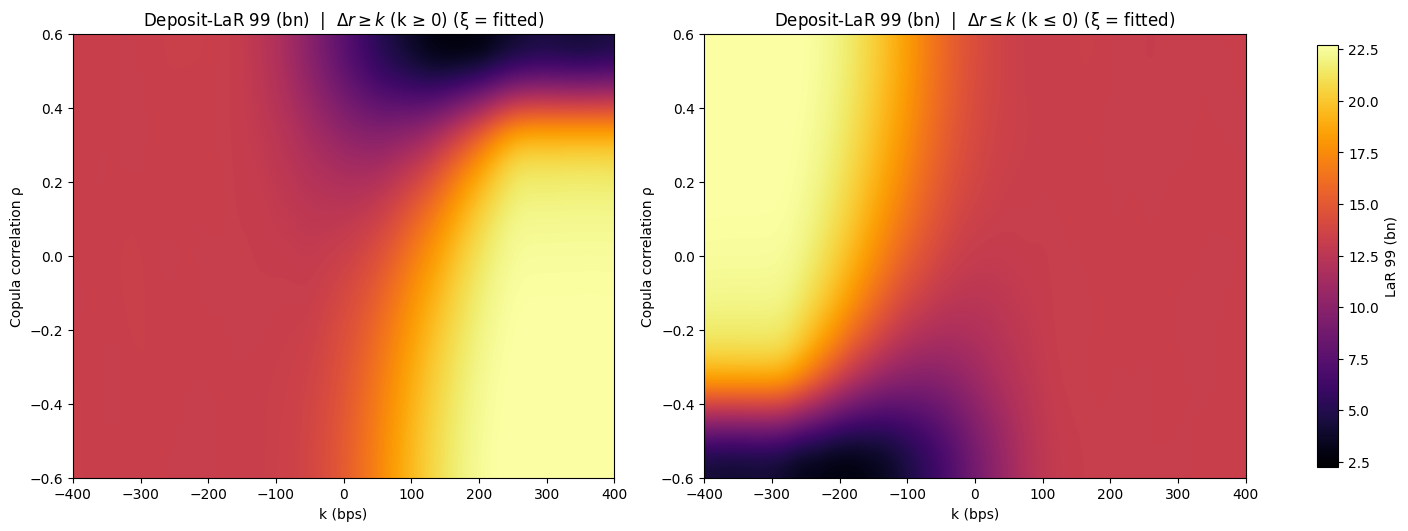

In [66]:
# --- shared color normalization across both panels ---
vmin = float(np.nanmin([lar_pos.min(), lar_neg.min()]))
vmax = float(np.nanmax([lar_pos.max(), lar_neg.max()]))

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("inferno")

fig, axes = plt.subplots(1, 2, figsize=(14, 5.2), constrained_layout=True)

im0 = axes[0].imshow(
    lar_pos,
    aspect="auto",
    origin="lower",
    interpolation="bicubic",
    extent=[k_grid.min(), k_grid.max(), rho_grid.min(), rho_grid.max()],
    cmap=cmap,
    norm=norm,
)
axes[0].set_title(r"Deposit-LaR 99 (bn)  |  $\Delta r \geq k$ (k ≥ 0) (ξ = fitted)")
axes[0].set_xlabel("k (bps)")
axes[0].set_ylabel("Copula correlation ρ")
axes[0].set_yticks(rho_grid)

im1 = axes[1].imshow(
    lar_neg,
    aspect="auto",
    origin="lower",
    interpolation="bicubic",
    extent=[k_grid.min(), k_grid.max(), rho_grid.min(), rho_grid.max()],
    cmap=cmap,
    norm=norm,
)
axes[1].set_title(r"Deposit-LaR 99 (bn)  |  $\Delta r \leq k$ (k ≤ 0) (ξ = fitted)")
axes[1].set_xlabel("k (bps)")
axes[1].set_ylabel("Copula correlation ρ")
axes[1].set_yticks(rho_grid)

# --- ONE shared colorbar (same gradient for both) ---
cbar = fig.colorbar(im0, ax=axes, shrink=0.95)
cbar.set_label("LaR 99 (bn)")

plt.show()

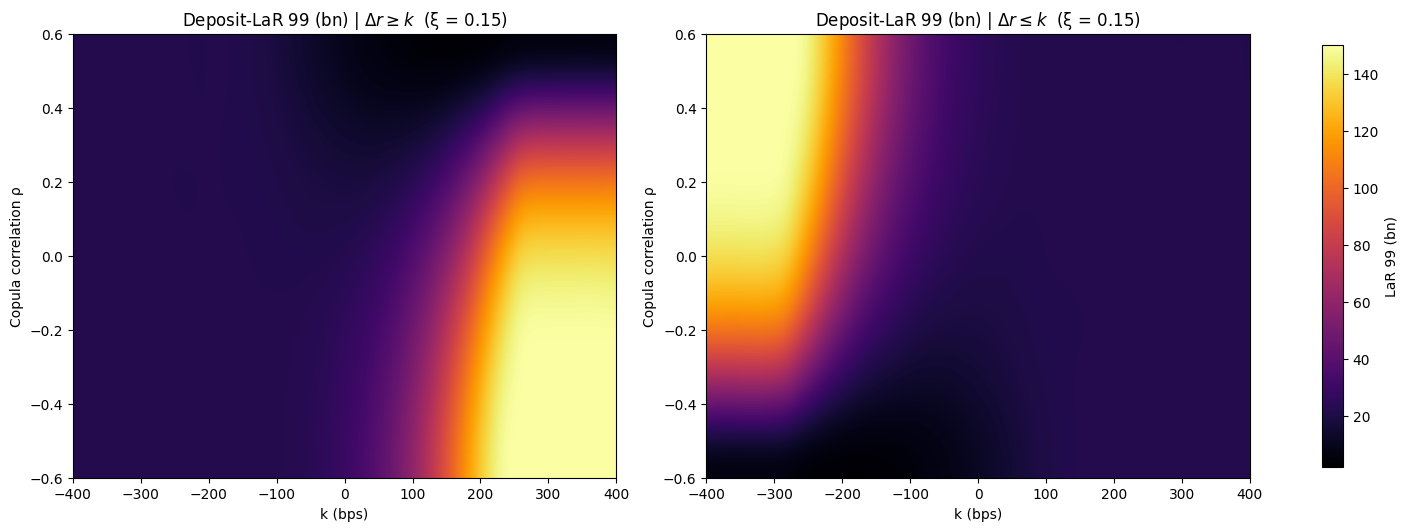

In [64]:
# --- minimal rerun with a custom GPD shape (override xi only) ---
xi_custom = 0.15  # <-- set whatever stress shape you want

lar_pos_xi = np.zeros((len(rho_grid), len(k_grid)))
lar_neg_xi = np.zeros((len(rho_grid), len(k_grid)))

for i, rho in enumerate(rho_grid):
    for j, k in enumerate(k_grid):

        # --------- Δr >= k ----------
        k_dec = float(k) / 10_000.0
        u_k = stats.norm.cdf(k_dec, loc=mu_d, scale=sd_d)
        u_k = float(np.clip(u_k, eps, 1 - eps))

        u = rng.uniform(u_k, 1 - eps, size=num_sim_cond)
        ty = stats.t.ppf(u, df=nu)

        tx = sample_tx_given_ty_vec(ty, rho, nu, rng)
        u_x = np.clip(stats.t.cdf(tx, df=nu), eps, 1 - eps)

        x_sim = semi_parametric_quantile_lefttail(
            u_x, x_sorted, p_grid,
            u_thresh=u_thresh, p_tail=p_tail,
            xi=xi_custom, beta=beta_hat
        )

        D1_th = D0_th * np.exp(x_sim)
        outflow_bn = np.maximum(D0_th - D1_th, 0.0) / 1e6
        lar_pos_xi[i, j] = float(np.quantile(outflow_bn, alpha))

        # --------- Δr <= k ----------
        u = rng.uniform(eps, u_k, size=num_sim_cond)
        ty = stats.t.ppf(u, df=nu)

        tx = sample_tx_given_ty_vec(ty, rho, nu, rng)
        u_x = np.clip(stats.t.cdf(tx, df=nu), eps, 1 - eps)

        x_sim = semi_parametric_quantile_lefttail(
            u_x, x_sorted, p_grid,
            u_thresh=u_thresh, p_tail=p_tail,
            xi=xi_custom, beta=beta_hat
        )

        D1_th = D0_th * np.exp(x_sim)
        outflow_bn = np.maximum(D0_th - D1_th, 0.0) / 1e6
        lar_neg_xi[i, j] = float(np.quantile(outflow_bn, alpha))

# --- plot with shared color scale ---
import matplotlib as mpl

vmin = float(np.nanmin([lar_pos_xi.min(), lar_neg_xi.min()]))
vmax = float(np.nanmax([lar_pos_xi.max(), lar_neg_xi.max()]))

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("inferno")

fig, axes = plt.subplots(1, 2, figsize=(14, 5.2), constrained_layout=True)

im0 = axes[0].imshow(
    lar_pos_xi,
    aspect="auto",
    origin="lower",
    interpolation="bicubic",
    extent=[k_grid.min(), k_grid.max(), rho_grid.min(), rho_grid.max()],
    cmap=cmap,
    norm=norm,
)
axes[0].set_title(rf"Deposit-LaR 99 (bn) | $\Delta r \geq k$  (ξ = {xi_custom:.2f})")
axes[0].set_xlabel("k (bps)")
axes[0].set_ylabel("Copula correlation ρ")
axes[0].set_yticks(rho_grid)

im1 = axes[1].imshow(
    lar_neg_xi,
    aspect="auto",
    origin="lower",
    interpolation="bicubic",
    extent=[k_grid.min(), k_grid.max(), rho_grid.min(), rho_grid.max()],
    cmap=cmap,
    norm=norm,
)
axes[1].set_title(rf"Deposit-LaR 99 (bn) | $\Delta r \leq k$  (ξ = {xi_custom:.2f})")
axes[1].set_xlabel("k (bps)")
axes[1].set_ylabel("Copula correlation ρ")
axes[1].set_yticks(rho_grid)

cbar = fig.colorbar(im0, ax=axes, shrink=0.95)
cbar.set_label("LaR 99 (bn)")

plt.show()

Copula dependence (latent t corr): rho_t_hat = -0.326
GPD left-tail on logflow: u=-0.01002731, p_tail=0.233, xi_hat=0.050, beta_hat=0.05
                                                    LaR_0.800  LaR_0.900  \
scenario                                                                   
Baseline (Historical Regime)                          21.5111    41.5336   
Policy Tightening (Higher Vol, Faster Mean Reve...    26.3571    47.9283   
Dovish Regime (Lower Rates, Lower Volatility)         16.7137    35.7281   
Hawkish Regime (Higher Level, Sustained Tighten...     6.0323    27.2109   

                                                    LaR_0.950  LaR_0.970  \
scenario                                                                   
Baseline (Historical Regime)                          56.3806    64.7873   
Policy Tightening (Higher Vol, Faster Mean Reve...    63.0107    71.8475   
Dovish Regime (Lower Rates, Lower Volatility)         49.9757    58.5370   
Hawkish Regime (Higher Lev

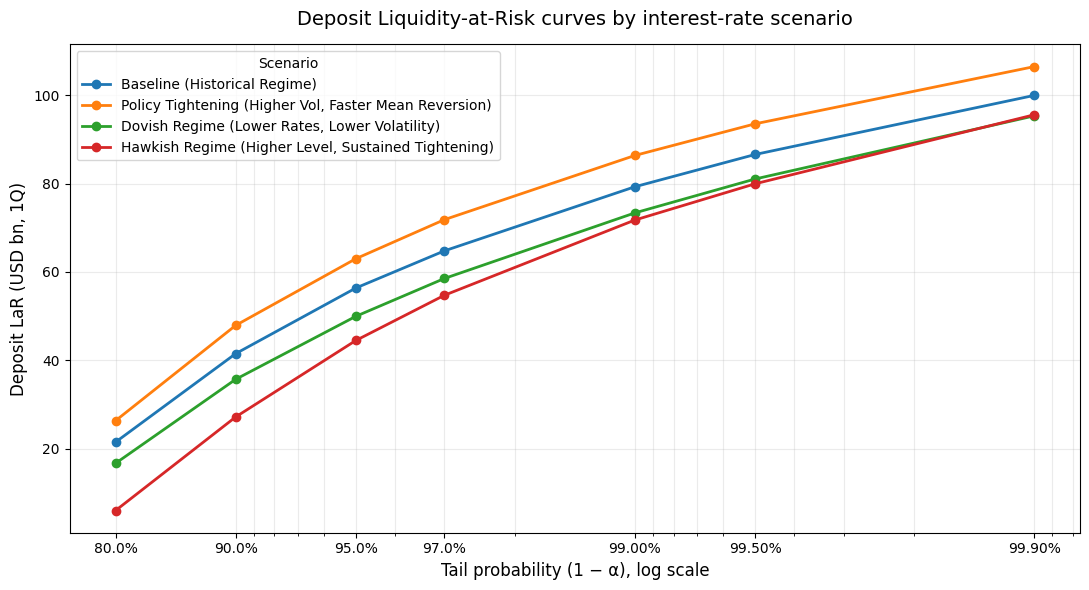

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# =========================================================
# 0) USER SETTINGS
# =========================================================
num_sim    = 250_000
nu_copula  = 10
T_horizon  = 0.25
alpha_grid = [0.95, 0.99]      # <-- ONLY 95 and 99
tail_q     = 0.10
min_tail   = 20
eps        = 1e-10
rng        = np.random.default_rng(42)

# =========================================================
# 1) BASE VASICEK PARAMS (already estimated in your notebook)
#     Vasicek: dr = kappa(theta - r) dt + sigma dW
# =========================================================
kappa_hat = float(a)
theta_hat = float(b)
sigma_hat = float(sigma)
base_params = {"kappa": kappa_hat, "theta": theta_hat, "sigma": sigma_hat, "r0": float(r0)}

# =========================================================
# 2) SCENARIOS (baseline + 3)
# =========================================================
scenarios = {
    "Baseline (Historical Regime)": {
        "delta_r0": 0.0,
        "delta_theta": 0.0,
        "sigma_mult": 1.0,
        "kappa_mult": 1.0,
    },

    "Policy Tightening (Higher Vol, Faster Mean Reversion)": {
        "delta_r0": 0.0,
        "delta_theta": 0.0,
        "sigma_mult": 1.8,
        "kappa_mult": 1.75,
    },

    "Dovish Regime (Lower Rates, Lower Volatility)": {
        "delta_r0": 0.0,
        "delta_theta": -0.0050,   # −50 bps long-run level
        "sigma_mult": 0.70,
        "kappa_mult": 0.80,
    },

    "Hawkish Regime (Higher Level, Sustained Tightening)": {
        "delta_r0": 0.075,       # +75 bps starting level
        "delta_theta": 0.0100,    # +100 bps long-run level
        "sigma_mult": 1.10,
        "kappa_mult": 1.00,
    },
}

# =========================================================
# 3) PANEL PREP + REQUIRED COLUMNS
# =========================================================
required_cols = [
    "report_date", "flow_total", "fed_funds",
    "total_deposits_domestic", "cash_and_balances",
    "interest_bearing_balances", "securities_afs_total",
]
missing = [c for c in required_cols if c not in panel.columns]
if missing:
    raise KeyError(f"`panel` missing required columns: {missing}")

panel = panel.copy()
panel["report_date"] = pd.to_datetime(panel["report_date"])
panel = panel.sort_values("report_date").reset_index(drop=True)

# X: log deposit flow
flow = pd.to_numeric(panel["flow_total"], errors="coerce").replace([np.inf, -np.inf], np.nan)
if (flow <= -1.0).any():
    bad_n = int((flow <= -1.0).sum())
    raise ValueError(f"flow_total has {bad_n} values <= -1.0; cannot take log1p.")
panel["log_dep_flow"] = np.log1p(flow)

# Y: quarterly rate change (decimal)
panel["fed_funds_dec"] = pd.to_numeric(panel["fed_funds"], errors="coerce") / 100.0
panel["fedfunds_change"] = panel["fed_funds_dec"].diff()

df = panel[["log_dep_flow", "fedfunds_change"]].dropna().copy()
x_hist = df["log_dep_flow"].to_numpy(dtype=float)
y_hist = df["fedfunds_change"].to_numpy(dtype=float)
n = len(df)
if n < 30:
    raise ValueError(f"Too few observations for copula fit (n={n}).")

# Latest balance sheet snapshot
latest = panel.iloc[-1]
D0_th = float(latest["total_deposits_domestic"])  # thousands
HQLA_th = (
    float(latest["cash_and_balances"])
    + float(latest["interest_bearing_balances"])
    + float(latest["securities_afs_total"])
)
HQLA_bn = HQLA_th / 1e6

# =========================================================
# 4) FIXED BASELINE MAPPING FOR Δr: smooth parametric CDF (Student-t fit to historical Δr)
#     This is the key step to avoid empirical support issues in the copula fit.
# =========================================================
df_t, loc_t, scale_t = stats.t.fit(y_hist)

def Fy_baseline(x):
    u = stats.t.cdf(x, df=df_t, loc=loc_t, scale=scale_t)
    return np.clip(u, eps, 1 - eps)

# =========================================================
# 5) t-COPULA FIT (latent t correlation)
# =========================================================
u_x = (stats.rankdata(x_hist, method="average") - 0.5) / n
u_y = (stats.rankdata(y_hist, method="average") - 0.5) / n
u_x = np.clip(u_x, eps, 1 - eps)
u_y = np.clip(u_y, eps, 1 - eps)

t_x = stats.t.ppf(u_x, df=nu_copula)
t_y = stats.t.ppf(u_y, df=nu_copula)
rho_t_hat = float(np.corrcoef(t_x, t_y)[0, 1])
print(f"Copula dependence (latent t corr): rho_t_hat = {rho_t_hat:+.3f}")

# =========================================================
# 6) SEMI-PARAMETRIC MARGINAL FOR X (empirical center + GPD left tail)
# =========================================================
def fit_left_tail_gpd(x, tail_q=0.10, min_tail=20):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n0 = len(x)
    if n0 < (min_tail + 5):
        raise ValueError(f"Not enough data for GPD: n={n0}")

    xs = np.sort(x)
    k = max(int(np.ceil(tail_q * n0)), int(min_tail))
    k = min(k, n0 - 5)

    u = xs[k - 1] + 1e-12
    tail = x[x < u]

    if len(tail) < min_tail:
        for kk in range(k + 1, n0 - 4):
            u = xs[kk - 1] + 1e-12
            tail = x[x < u]
            if len(tail) >= min_tail:
                break

    if len(tail) < min_tail:
        raise ValueError(f"Too few tail points after tie-handling (got {len(tail)}).")

    p_tail = float(len(tail) / n0)
    L = np.clip(u - tail, 1e-12, None)  # exceedances on left tail
    xi_hat, _, beta_hat = stats.genpareto.fit(L, floc=0.0)
    return float(u), float(p_tail), float(xi_hat), float(beta_hat)

def sp_quantile_lefttail(u, x_sorted, p_grid, u_thresh, p_tail, xi, beta):
    u = np.asarray(u, dtype=float)
    out = np.empty_like(u)

    center = (u > p_tail)
    if np.any(center):
        out[center] = np.interp(u[center], p_grid, x_sorted)

    tail = ~center
    if np.any(tail):
        v = np.clip(u[tail] / max(p_tail, eps), eps, 1 - eps)
        qL = stats.genpareto.ppf(1.0 - v, c=xi, loc=0.0, scale=beta)
        out[tail] = u_thresh - qL
    return out

u_thresh, p_tail, xi_hat, beta_hat = fit_left_tail_gpd(x_hist, tail_q=tail_q, min_tail=min_tail)

xi_hat = 0.05  # <-- override with stressed shape if desired
beta_hat = 0.05 # keep original scale

x_sorted = np.sort(x_hist)
p_grid_x = (np.arange(len(x_sorted)) + 0.5) / len(x_sorted)

print(f"GPD left-tail on logflow: u={u_thresh:.7g}, p_tail={p_tail:.3f}, xi_hat={xi_hat:.3f}, beta_hat={beta_hat:.6g}")

# =========================================================
# 7) VASICEK: simulate Δr over horizon T
# =========================================================
def vasicek_delta_r_draws(kappa, theta, sigma, r0, T, size, rng):
    kappa = float(max(kappa, 1e-10))
    mT = theta + (r0 - theta) * np.exp(-kappa * T)
    vT = (sigma**2 / (2.0 * kappa)) * (1.0 - np.exp(-2.0 * kappa * T))
    sdT = float(np.sqrt(max(vT, 0.0)))
    rT = rng.normal(loc=mT, scale=sdT, size=size)
    return (rT - r0)

# =========================================================
# LaR curve settings (levels + x-axis)
# =========================================================
alpha_grid = np.array([0.80, 0.90, 0.95, 0.97, 0.99, 0.995, 0.999], dtype=float)
tail_prob  = 1.0 - alpha_grid   # x-axis = tail probability
# (We'll plot tail probability on log scale; smaller = more extreme)

# =========================================================
# Simulate scenarios and compute LaR curve for each
# =========================================================
def simulate_scenario_LaR_curve(params, scenario_name, sc, rho, xi=xi_hat):
    kappa = params["kappa"] * sc["kappa_mult"]
    theta = params["theta"] + sc["delta_theta"]
    sig   = params["sigma"] * sc["sigma_mult"]
    r0_s  = params["r0"] + sc["delta_r0"]

    # (i) simulate Δr (decimal)
    delta_r_sim = vasicek_delta_r_draws(kappa, theta, sig, r0_s, T_horizon, num_sim, rng)

    # (ii) map Δr -> u_y using FIXED baseline CDF
    u_y_sim = Fy_baseline(delta_r_sim)
    t_y_sim = stats.t.ppf(u_y_sim, df=nu_copula)

    # (iii) sample Tx | Ty (vectorized)
    df_cond = nu_copula + 1
    mu_cond = rho * t_y_sim
    scale2  = ((nu_copula + t_y_sim**2) / (nu_copula + 1.0)) * (1.0 - rho**2)
    scale   = np.sqrt(np.maximum(scale2, 1e-16))
    t_x_sim = mu_cond + scale * rng.standard_t(df_cond, size=num_sim)

    # (iv) Tx -> u_x -> logflow
    u_x_sim = np.clip(stats.t.cdf(t_x_sim, df=nu_copula), eps, 1 - eps)
    logflow_sim = sp_quantile_lefttail(u_x_sim, x_sorted, p_grid_x, u_thresh, p_tail, xi, beta_hat)

    # (v) deposits and outflows
    D1_th = D0_th * np.exp(logflow_sim)
    outflow_bn = np.maximum(D0_th - D1_th, 0.0) / 1e6

    # (vi) LaR curve
    out = {"scenario": scenario_name}
    for a_ in alpha_grid:
        out[f"LaR_{a_:.3f}"] = float(np.quantile(outflow_bn, a_))
    return out

rows = []
for name, sc in scenarios.items():
    rows.append(simulate_scenario_LaR_curve(base_params, name, sc, rho=rho_t_hat, xi=xi_hat))

res_df = pd.DataFrame(rows).set_index("scenario")
print(res_df.round(4))

# =========================================================
# Plot: LaR threshold curve (x = tail prob on log scale), lines = scenarios
# =========================================================
fig, ax = plt.subplots(figsize=(11.0, 6.0))

for scen in res_df.index:
    lar_vals = np.array([res_df.loc[scen, f"LaR_{a_:.3f}"] for a_ in alpha_grid], dtype=float)
    ax.plot(tail_prob, lar_vals, marker="o", linewidth=2, label=scen)

ax.set_xscale("log")
ax.invert_xaxis()  # smaller tail probs (more extreme) to the right (optional but usually nicer)

ax.set_xlabel("Tail probability (1 − α), log scale", fontsize=12)
ax.set_ylabel("Deposit LaR (USD bn, 1Q)", fontsize=12)
ax.set_title("Deposit Liquidity-at-Risk curves by interest-rate scenario", fontsize=14, pad=14)

# Nice x tick labels at your α points
ax.set_xticks(tail_prob)
ax.set_xticklabels([f"{a*100:.1f}%" if a < 0.99 else f"{a*100:.2f}%" for a in alpha_grid], rotation=0)

ax.grid(True, which="both", axis="both", alpha=0.25)
ax.legend(title="Scenario", frameon=True)
plt.tight_layout()
plt.show()

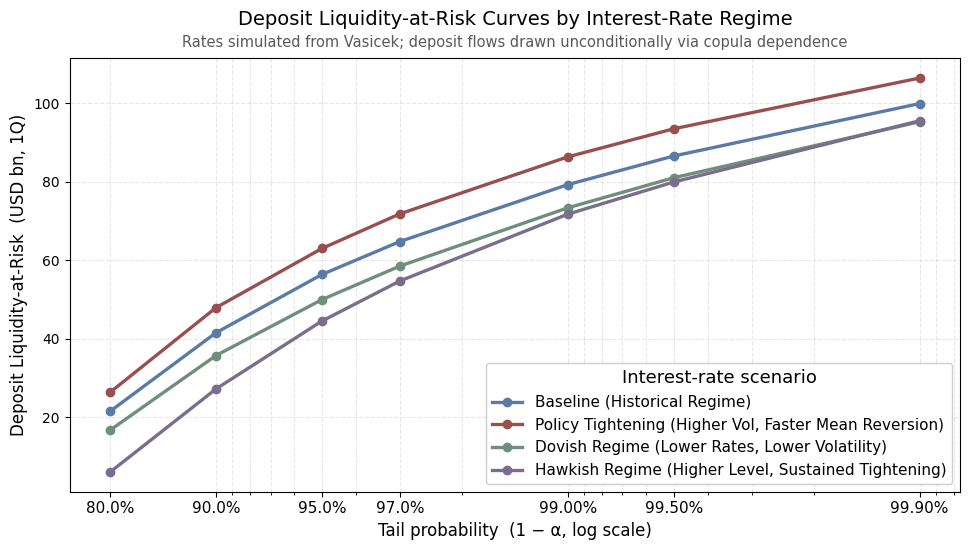

In [97]:
fig, ax = plt.subplots(figsize=(9.8, 5.6))

# --- Professional color palette (colorblind-safe, muted) ---
palette = {
    "Baseline (Historical Regime)": "#5A7BA5",   # muted steel blue
    "Policy Tightening (Higher Vol, Faster Mean Reversion)": "#9A4F4F",  # muted brick red
    "Dovish Regime (Lower Rates, Lower Volatility)": "#6F8F7A",          # muted sage green
    "Hawkish Regime (Higher Level, Sustained Tightening)": "#7B6D8D",    # muted slate purple
}

# --- Plot LaR curves ---
for scen in res_df.index:
    lar_vals = np.array(
        [res_df.loc[scen, f"LaR_{a_:.3f}"] for a_ in alpha_grid],
        dtype=float
    )

    ax.plot(
        tail_prob,
        lar_vals,
        marker="o",
        markersize=6,
        linewidth=2.4,
        color=palette.get(scen, "black"),
        label=scen,
    )

# --- Axes scaling & orientation ---
ax.set_xscale("log")
ax.invert_xaxis()   # extreme tail (smaller prob) to the right

# --- Labels ---
ax.set_xlabel("Tail probability  (1 − α, log scale)", fontsize=12)
ax.set_ylabel("Deposit Liquidity-at-Risk  (USD bn, 1Q)", fontsize=12)

# --- Title + subtitle (explicitly unconditional) ---
ax.set_title(
    "Deposit Liquidity-at-Risk Curves by Interest-Rate Regime",
    fontsize=14,
    pad=24,
)

ax.text(
    0.5,
    1.02,
    "Rates simulated from Vasicek; deposit flows drawn unconditionally via copula dependence",
    transform=ax.transAxes,
    ha="center",
    va="bottom",
    fontsize=10.5,
    color="0.35",
)

# --- Custom ticks (expressed as α levels) ---
ax.set_xticks(tail_prob)
ax.set_xticklabels(
    [f"{a*100:.1f}%" if a < 0.99 else f"{a*100:.2f}%" for a in alpha_grid],
    fontsize=11,
)

# --- Grid & cosmetics ---
ax.grid(True, which="both", axis="both", linestyle="--", linewidth=0.8, alpha=0.3)
ax.set_axisbelow(True)

# --- Legend ---
ax.legend(
    title="Interest-rate scenario",
    title_fontsize=13,
    fontsize=11,
    frameon=True,
    framealpha=0.95,
    loc="lower right",
)

plt.tight_layout()
plt.show()